## Simulamos MC seleccionando al azar un valor de "r" con distribución normal (como la que nos salía al hacer el cálculo de "r" con MC_pairs). Calculamos "std" a partir de "Interv_A"

In [17]:
# Organización de datos
import pandas as pd
import numpy as np
import sympy

# Visualizacicón de datos
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Cálculo de ajustes matemáticos a los datos

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats

import statsmodels.api as sm
alpha=0.05 # 95% confidence interval

# Funciones
# import funciones_jmp as f

In [18]:
def f_exponen_shift(x, a, b, c):
    """
    Función exponencial negativa de la forma    y = a * exp(-b * x) - c 

    Parámetros:
    x -- valor de entrada
    a, b, c -- parámetros de la función exponencial (c>0)

    Retorna:
    El valor de la función exponencial evaluada en x
    """
    return a * np.exp(-b * x) - c

In [19]:
def f_exponen_shift_inv(y, a, b, c):
    """
    Inversa de la Función exponencial negativa de la forma    y = a * exp(-b * x) - c 
    Quedando:  x = -1/b * ln( (y+c)/a)
    Parámetros:
    y -- valor de entrada
    a, b, c -- parámetros de la función exponencial (c>0)

    Retorna:
    El valor X que da en la función exponencial un valor de "y"
    """
    if (y+c)/a >0:
        return -1./b * np.log( (y+c)/a ) 
    else:
        return 1e10

In [46]:
#### Hace bootstrap tomando como distribución una NORMAL de sigma=std=intervalo_conf/t

def IC50_ICr0_ICrmed_nboot_MC_norm_estad(X, y, error_y, n_boot, n_samples_fit_r, time, name, save=False): ## no se corta si no consigue el ajuste con curve_Fit, busca con el siguiente

    '''
    Calcula el valor de IC50, de ICr0 y el ICrmed (concentración para el que la tasa de crecimiento es la mitad que la del control)
    por el método de Bootstrap: itera tomando al azar valores
    aleatorios en el rango entre ymin-ymax para cada concentración, ajusta una exponencial decreciente desplazada
    y lo va promediando
    Devuelve el valor meadio de IC50, ICr0, ICrmed y sus desviaciones:
    ICr0mean, Delta_ICr0, IC50mean, Delta_IC50, ICrmed, Delta_ICrmed
    '''
    X0 = np.array(X).ravel()
    X = X0
    y0 = np.array(y).ravel()
    y = y0
    e = np.array(error_y).ravel()
    print('y0',y0)
    r_IC50 = y[0]+np.log(0.5)/time
    rmed = y[0]/2.
    print('r_IC50:', r_IC50, 'r[0]:', y[0], 'rmed:', rmed)
    
#     n_samples = 12 ## n_samples used in r_rpom_repl
    
    t = stats.t.ppf(0.95, n_samples_fit_r-2) 
    e_std = e/t
    print('t:',t, 'e_std:', e_std)
    
#     popt, pcov = curve_fit(f_exponen_shift, X, y, sigma=e, absolute_sigma=True)
#     A = popt[0]
#     B = popt[1]
#     C = popt[2]
#     print('param:',popt, 'A:',A, 'B:',B, 'C:', C)
#     y_hat = f_exponen_shift(X, *popt)
#     resid = y - y_hat
#     print('resid:',resid)

    print('n_boot:', n_boot)
    n_points = n_boot
    n_samples = len(X)
    n_param = 3     ## Shifted exponential: A*exp(B * X) +C    

        
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float)
#     slopes_b = np.zeros(n_boot, dtype=float)
    params_b = np.zeros((n_boot, n_param), dtype=float)

#     IC50_b = np.zeros((n_boot), dtype = float)
#     ICr0_b = np.zeros((n_boot), dtype = float)
#     ICrmed_b = np.zeros((n_boot), dtype = float)
    IC50inv_b = np.zeros((n_boot), dtype = float)
    ICr0inv_b = np.zeros((n_boot), dtype = float)
    ICrmedinv_b = np.zeros((n_boot), dtype = float)
    r2_b = np.zeros((n_boot), dtype = float)
#     resids_b = np.zeros((n_boot, n_samples), dtype=float)

#     errors = np.zeros(n_boot, dtype=float)
        
#     fig = plt.figure(figsize=(10,6))
#     fig, axs = plt.subplots(2, 1, figsize=(10, 4))
#     subfigs = fig.add_subplot(2, 1, 1)
    

    fig = plt.figure(figsize=(18,18))
    gs = GridSpec(2, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
       
    npoints_plot = 1000
    X_plot = np.linspace(0,X[-1],npoints_plot)
#     y_plot_b = np.zeros((n_boot, npoints_plot), dtype=float)
#     creciente = np.all(np.diff(X) > 0)
#     print('Orden creciente:', creciente)
          
#     nfit=0
    i_fit=0
#     res_b = 0
    for i_b in range(n_boot):
#         print('iter/n_iter:',i_b, '/',n_boot)
        y_boot = []
        for j in range(len(X0)):
            y_j = np.random.normal(y0[j],e_std[j], 1)[0]
            y_boot.append(y_j)     
            
        print('y_boot:', y_boot)

#         try:
        popt_b, pcov_b = curve_fit(f_exponen_shift, X0, y_boot, bounds=(0, [10,10,10]))
        print('param:',popt_b, 'pcov:', pcov_b)

        y_hat_i = f_exponen_shift(X0, *popt_b)
        res_b = y_boot - y_hat_i

        sum_resid = np.abs(res_b).sum()             
        all_lt_10 = (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[2][2])<10) ##TODOS los parámetros tienen que ser < 2
        if (all_lt_10) and (sum_resid<10):

            y_hat_b[i_fit,:] = y_hat_i

#                 resid_b = res_b.sum()                    
#                 if (resid_b >1):
#                     print('\n\n\nCUIDADO!!!!! Residuos altos!!! Suma:', resid_b, '\n\n\n')
# 
#                 IC50_b[i_fit] = np.interp(r_IC50, np.flip(y_hat), np.flip(X))
#                 ICr0_b[i_fit] = np.interp(0., np.flip(y_hat), np.flip(X))
#                 ICrmed_b[i_fit] = np.interp(rmed, np.flip(y_hat), np.flip(X))
            IC50inv_b[i_fit] = f_exponen_shift_inv(r_IC50, *popt_b)
            ICr0inv_b[i_fit] = f_exponen_shift_inv(0.0, *popt_b)
            ICrmedinv_b[i_fit] = f_exponen_shift_inv(rmed, *popt_b)
            r2_b[i_fit] = r2_score(y_boot, y_hat_i)
            print('IC50inv:',IC50inv_b[i_fit], 'ICr0inv:', ICr0inv_b[i_fit], 'ICremdinv', ICrmedinv_b[i_fit])

            if (IC50inv_b[i_fit]<100) and (ICr0inv_b[i_fit]<100) and (ICrmedinv_b[i_fit]<100):      
                params_b[i_fit,:] = popt_b[:]
#                         resid_b = y - y_hat            
#                     resids_b[i_fit,:] = res_b
#                     print('resids_b ok')

#                     print('params:', params_b[i_fit,:], 'resid_b:', resids_b[i_fit,:])
#                 print('Función inversa -- IC50_b:', IC50inv_b[i_fit], 'ICr0_b:', ICr0inv_b[i_fit], 'ICrmed_b:', ICrmedinv_b[i_fit])

                y_plot = f_exponen_shift( X_plot, *popt_b)
#                 y_plot_b[i_fit,:] = y_plot
                ax1.plot(X_plot, y_plot, color='grey', alpha=0.2, zorder=1)
                ax1.scatter(X, y_boot, marker='o', color='orange', zorder=2)
#                         ax1.scatter(X_boot, y_boot, marker='o', color='orange', zorder=2)
                i_fit += 1
                if (i_b%100 ==0):
                    print('fit Ok, i_b',i_b, ', i_fit:', i_fit)
            else:
                print('\n\n\nCUIDADO!!!!! Residuos altos o paránetros grandes!!! Suma:', np.abs(res_b).sum(), '\n\n\n')

    nfit = i_fit
#     res_b /= nfit        
################
    print('i_fit:',i_fit, 'nfit:', nfit)    
    print('params_b[:20,:]', params_b[:20,:])
    print('IC50inv[:20,:]', IC50inv_b[:20])

    params_mean = np.mean(params_b[:nfit,:], axis=0)

    IC50inv_mean = np.mean(IC50inv_b[:nfit])
    ICr0inv_mean = np.mean(ICr0inv_b[:nfit])
    ICrmedinv_mean = np.mean(ICrmedinv_b[:nfit])
    print('params_inv_mean=', params_mean)    
    
    sum_res2_IC50inv = np.sum((IC50inv_b[:nfit] - IC50inv_mean)**2)    
    sum_res2_ICr0inv = np.sum((ICr0inv_b[:nfit] - ICr0inv_mean)**2)    
    sum_res2_ICrmedinv = np.sum((ICrmedinv_b[:nfit] - ICrmedinv_mean)**2) 

    SE_IC50inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_IC50inv / (nfit-1)) ## 2 degrees of freedom
    SE_ICr0inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICr0inv / (nfit-1)) ## 2 degrees of freedom
    SE_ICrmedinv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICrmedinv / (nfit-1)) ## 2 degrees of freedom
    t = stats.t.ppf(0.95, n_samples-1)  #### antes ponía n_samples-2 pero estamos promediando los valores obtenidos por bootstrap 

    Interv_IC50inv = t * SE_IC50inv
    Interv_ICr0inv = t * SE_ICr0inv
    Interv_ICrmedinv = t * SE_ICrmedinv

    print('r[0]:', y[0], ',  r_IC50:', r_IC50, ';  rmed:', rmed)

    print('IC50inv_mean:',IC50inv_mean, 'SE_IC50inv:', SE_IC50inv, 'Interval:', Interv_IC50inv)
    print('ICr0inv_mean:',ICr0inv_mean, 'SE_ICr0inv:', SE_ICr0inv, 'Interval:', Interv_ICr0inv)
    print('ICrmedinv_mean:',ICrmedinv_mean, 'SE_ICrmedinv:', SE_ICrmedinv, 'Interval:', Interv_ICrmedinv)
        
    ymin_plot, ymax_plot = ax1.get_ylim()
    xmin_plot, xmax_plot = ax1.get_xlim()
    print('ymin', ymin_plot)
    ax1.margins(0.01)
    
    yhat_mean = np.mean(y_hat_b, axis=0)
    ax1.plot(X, yhat_mean, color='green', label='average_fit')

    yfit_mean = f_exponen_shift(X_plot, params_mean[0], params_mean[1], params_mean[2])
    ax1.plot(X_plot, yfit_mean, color='red', label='average_params')

    
    label_IC50 = f'IC50:{IC50inv_mean:.1f}, error:{Interv_IC50inv:.1f} (r_IC50:{r_IC50:.2f})' 
    ax1.hlines(y=0, xmin=xmin_plot, xmax=xmax_plot, colors='black')
    ax1.plot([IC50inv_mean, IC50inv_mean], [ymin_plot, r_IC50], 'k:', label=label_IC50) ##vertical
    ax1.plot([0, IC50inv_mean], [r_IC50, r_IC50], 'k:') ##horizontal

    label_ICrmed = f'ICrmed:{ICrmedinv_mean:.1f}, error:{Interv_ICrmedinv:.1f} (rmed:{rmed:.2f})' 
    ax1.plot([ICrmedinv_mean, ICrmedinv_mean], [ymin_plot, rmed], 'm-.' , label=label_ICrmed) ##vertical
    ax1.plot([0, ICrmedinv_mean], [rmed, rmed], 'm-.') ##horizontal

    label_ICr0 =f'ICr0:{ICr0inv_mean:.1f}, error:{Interv_ICr0inv:.1f}' 
    ax1.plot([ICr0inv_mean, ICr0inv_mean], [ymin_plot, 0], 'g--', label=label_ICr0) ##vertical
    ax1.plot([0, ICr0inv_mean], [0,0],  'g--') ##horizontal
    
    ax1.set_xlabel('Cisplatin concentration (uM)')
    ax1.set_ylabel('Growth rate (r)')
    ax1.set_title(f'IC50_boot_MC_norm (file: {name}); t:{time}; n_boot (MC): {n_boot} ')
    ax1.margins(0.02)

    ax1.grid(True)
    ax1.legend()
    
############  Statistics -- histogram ---    
    
#     for i in range(20):
#         print('Residuos de i:', i,'residuos:', resids_b[i,:])
#     data= [3.57520101e-02,4.00859322e-02,-2.11721168e-02,-4.29976386e-02,-9.18274081e-03,-1.94597547e-02,-5.21101356e-04,8.53677767e-03,5.28447647e-02,-3.74638446e-02,5.01940067e-02,3.90928055e-02,4.24452929e-02,-1.97764058e-02,-4.34768719e-02,-1.32092683e-02,-2.98225518e-02,-2.09018132e-02,-2.37678784e-02,1.53576224e-02,-6.32996180e-02,4.00495229e-02,1.20900075e-02,1.62646525e-02,-4.51455046e-02,-6.72542427e-02,-3.39252310e-02,-4.48779919e-02,-2.62945223e-02,-1.51710055e-02,3.81188653e-02,-3.52268012e-02,6.47322397e-02,3.43550812e-02,3.86750845e-02,-2.25980591e-02,-4.44571886e-02,-1.07224498e-02,-2.12060615e-02,-2.82695505e-03,4.76710207e-03,4.59140045e-02,-4.87195656e-02,3.65046785e-02,2.92369209e-02,3.30566758e-02,-2.87062392e-02,-5.15141306e-02,-1.95582180e-02,-3.31583070e-02,-1.94898972e-02,-1.68060493e-02,2.41843602e-02,-6.18632219e-02,3.15650940e-02,2.69983892e-02,3.12022229e-02,-3.01859068e-02,-5.22715059e-02,-1.89760230e-02,-3.02859401e-02,-1.33693704e-02,-8.06943027e-03,3.02391350e-02,-6.66170422e-02,1.78636154e-02,3.67767897e-02,4.08688943e-02,-2.06271139e-02,-4.29171954e-02,-9.98746147e-03,-2.18702388e-02,-5.56645715e-03,-8.50910345e-06,4.14573326e-02,-4.89557841e-02,3.98859918e-02,3.33286918e-02,3.74244609e-02,-2.40641206e-02,-4.63283599e-02,-1.33050028e-02,-2.48480445e-02,-7.36400701e-03,1.86039308e-03,5.23532936e-02,-2.39315938e-02,7.44750937e-02,5.75892680e-02,6.09689004e-02,-1.23302180e-03,-2.49154932e-02,5.30558769e-03,-1.17025727e-02,-4.57611882e-03,-1.37406313e-02,8.72045971e-03,-9.77565137e-02,-1.50236906e-02,4.05826064e-02,4.47655643e-02,-1.66398915e-02,-3.87497843e-02,-5.46342651e-03,-1.66486014e-02,9.83894609e-04,8.91675871e-03,5.40212989e-02,-3.24967286e-02,5.82998997e-02]
    n_bins=20
#     resids_plot = resids_b[:nfit,:].ravel()
    r2_plot = r2_b[:nfit].ravel()
    print('r^2_min:', r2_plot.min(), ';   r^2_max:',r2_plot.max())
#     print('residuos:', np.array(resids_plot))
#     print('resid_min:', resids_plot.min(), ';   resid_max:',resids_plot.max())
# We can set the number of bins with the *bins* keyword argument.
    ax2.hist(r2_plot, density=False, bins=n_bins, range=(r2_plot.min(), r2_plot.max()),histtype='barstacked', rwidth=0.8)
    ax2.set_title('r^2 distrib.')
#     ax2.set_xlim((0,50))    
    ax3.hist(IC50inv_b[:nfit], bins=n_bins, range=(IC50inv_b.min(), IC50inv_b.max()), histtype='barstacked', rwidth=0.8)
#     ax3.set_xlim((0,50))
    ax3.set_title('IC50 distrib.')
    
        
    if save:
        filename = name + '_IC50_ICrmed_ICr0_boot_MC_norm_SE_estad.jpg'
        plt.savefig(filename)

    plt.show()
    
    return (IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv)

In [47]:

# name = 'DLD1normv2r_MTT_boot_MC_err'
name = 'SW620norm_nov23_0_2days_r_boot_pairs_0_2days_err'
# name = 'HCT116normr_MTT_boot_MC_err'


# name = 'DLD1normC_prom_repl_MTT_r_boot_MC_err'
filename = name + '.xlsx' #'SW480_oct23.xlsx')

df = pd.read_excel(filename)


In [48]:
df.head()

,Unnamed: 0,concentr,prom_r,err_r
0,0,0.000000,0.238182,0.065505
1,1,0.097656,0.214874,0.083179
2,2,0.195312,0.131654,0.068131
3,3,0.390625,0.126563,0.074765
4,4,0.781250,0.131550,0.077185


In [49]:
X0 = df['concentr']
y0 = df['prom_r']
e = df['err_r']
print(e)

0     0.065505
1     0.083179
2     0.068131
3     0.074765
4     0.077185
5     0.092863
6     0.108641
7     0.077346
8     0.054306
9     0.041420
10    0.031634
Name: err_r, dtype: float64


In [50]:
Concentr = X0
slopes = y0
err_slopes = e

In [61]:
######################################
######  Esto solo para HT29 porque el último punto hace que no ajuste bien
#####################################

Concentr = X0[:-1]
slopes = y0[:-1]
err_slopes = e[:-1]
name = name + '_25'

In [51]:
err_slopes

0     0.065505
1     0.083179
2     0.068131
3     0.074765
4     0.077185
5     0.092863
6     0.108641
7     0.077346
8     0.054306
9     0.041420
10    0.031634
Name: err_r, dtype: float64

y0 [ 0.23818163  0.21487414  0.13165397  0.12656346  0.13155038  0.07021186
  0.02182184  0.01883248  0.02039892 -0.1964555  -0.23379187]
r_IC50: 0.0071325660988095785 r[0]: 0.238181626285458 rmed: 0.119090813142729
t: 1.74588367627624 e_std: [0.03751947 0.04764308 0.0390237  0.04282361 0.04420979 0.05318992
 0.06222683 0.04430218 0.03110542 0.02372443 0.01811906]
n_boot: 2000
y_boot: [0.24371979123849488, 0.17730023979598944, 0.1549854797142325, 0.13697763287466092, 0.15328056914777594, 0.12771902564299065, 0.10665502219876602, -0.06266259556776173, 0.06543517757863399, -0.2138628618406547, -0.22772446707762625]
param: [0.43319637 0.06078149 0.2575348 ] pcov: [[ 0.00757674 -0.00197685  0.00737903]
 [-0.00197685  0.00098002 -0.00235322]
 [ 0.00737903 -0.00235322  0.00795915]]
IC50inv: 8.106370898161975 ICr0inv: 8.555832682153339 ICremdinv 2.302337681103052
fit Ok, i_b 0 , i_fit: 1
y_boot: [0.16797177388102263, 0.24469678179366686, 0.18731639133163536, 0.11130183719168855, 0.11322744858

y_boot: [0.23573249348335198, 0.27905676925026, 0.1422699130937477, 0.09243731565077826, 0.11430200812344071, 0.020850838403207818, 0.032733180811998344, 0.010522068391269151, -0.011242449932793133, -0.18488202319610286, -0.24483767336893675]
param: [0.40667505 0.07164433 0.2453079 ] pcov: [[ 0.00693184 -0.00212513  0.00650423]
 [-0.00212513  0.00155565 -0.0026613 ]
 [ 0.00650423 -0.0026613   0.00705805]]
IC50inv: 6.655641980067239 ICr0inv: 7.055691592919245 ICremdinv 1.5320936879594356
y_boot: [0.256239419299352, 0.23993439068320932, 0.11015379741484858, 0.10261932193673612, 0.20358189674992727, 0.07879440811524395, -0.03198682409391306, 0.049561450887265476, 0.07333274397562854, -0.16326784771734976, -0.25616447229512307]
param: [0.4940567  0.03708508 0.33296618] pcov: [[ 0.04667443 -0.00658743  0.04786862]
 [-0.00658743  0.00113852 -0.00709577]
 [ 0.04786862 -0.00709577  0.05028055]]
IC50inv: 10.069125188377626 ICr0inv: 10.64065109720366 ICremdinv 2.3956271978987806
y_boot: [0.23970

y_boot: [0.16814661565987993, 0.26611164147405064, 0.17173151337482004, 0.08098327216404481, 0.150957096372433, 0.032861050124023135, -0.05819506781728186, -0.00047460603051667147, 0.043512234776128395, -0.20220489122747604, -0.21208321563250343]
param: [0.36295725 0.07977607 0.21324605] pcov: [[ 0.00841907 -0.00303983  0.00767777]
 [-0.00303983  0.00309725 -0.00395672]
 [ 0.00767777 -0.00395672  0.00835895]]
IC50inv: 6.254231869501774 ICr0inv: 6.666641098695033 ICremdinv 1.1047920437510916
y_boot: [0.20595925484044722, 0.23329565125282833, 0.088769586090788, 0.138096363199344, 0.1772216224244376, 0.05345140320740552, 0.043709677623989834, 0.038624748437100245, 0.03770012805281718, -0.2516261418392171, -0.20649913108314194]
param: [0.41565244 0.06160006 0.25332343] pcov: [[ 0.00858392 -0.00235549  0.00833747]
 [-0.00235549  0.00124944 -0.00281452]
 [ 0.00833747 -0.00281452  0.00899788]]
IC50inv: 7.5879071836040834 ICr0inv: 8.03866772099881 ICremdinv 1.7831581432607886
y_boot: [0.231829

y_boot: [0.15201593547415668, 0.17726301507796832, 0.16432218725602663, 0.10883084231836673, 0.1263204900472532, 0.1118146894257403, -0.014443502457429896, 0.047685906538875486, 0.011792081984503055, -0.20727075895913707, -0.22005253692813892]
param: [0.40242737 0.05523442 0.2584419 ] pcov: [[ 0.00540594 -0.0014138   0.0053565 ]
 [-0.0014138   0.00062615 -0.00164119]
 [ 0.0053565  -0.00164119  0.00575315]]
IC50inv: 7.524644562881163 ICr0inv: 8.017532277015768 ICremdinv 1.1561163763621825
y_boot: [0.2054643180664421, 0.2442938216191895, 0.08625324222356831, 0.10826958587602169, 0.19120637950289116, -0.024418491559241917, -0.05639882411191207, 0.04256626569729747, 0.0005106692592135101, -0.19758911730323697, -0.23796447791272649]
param: [0.38846145 0.06685429 0.2471719 ] pcov: [[ 0.0119823  -0.00370312  0.01143276]
 [-0.00370312  0.00247137 -0.00453409]
 [ 0.01143276 -0.00453409  0.01237696]]
IC50inv: 6.337090549270746 ICr0inv: 6.762615780551297 ICremdinv 0.8801689711649675
y_boot: [0.25

y_boot: [0.18942091449583282, 0.2785642651182611, 0.14038320257400622, 0.09945991680309837, 0.14736301253481038, 0.06848661306373716, -0.013455637590315477, 0.027422395456010877, 0.012132679643059691, -0.21470389694857273, -0.22617103058860283]
param: [0.40511101 0.070123   0.2433281 ] pcov: [[ 0.00689358 -0.00209791  0.00650295]
 [-0.00209791  0.00147675 -0.00260842]
 [ 0.00650295 -0.00260842  0.00705166]]
IC50inv: 6.857368604640115 ICr0inv: 7.269375352693197 ICremdinv 1.5880719928709273
y_boot: [0.2525928866292812, 0.1446728422666989, 0.1177745913043257, 0.1300291000376196, 0.1762439479446798, 0.0026926459163199162, 0.044153996136930385, 0.05131665630341975, -0.0045546558688092965, -0.2489072148999898, -0.2286625921976073]
param: [0.42358369 0.06196764 0.26983209] pcov: [[ 0.00828883 -0.00224082  0.00804107]
 [-0.00224082  0.0011801  -0.00268204]
 [ 0.00804107 -0.00268204  0.00868008]]
IC50inv: 6.856179153707374 ICr0inv: 7.27720579739333 ICremdinv 1.3776544465989475
y_boot: [0.198942

param: [0.46532316 0.04390875 0.3040652 ] pcov: [[ 0.00884677 -0.00161158  0.00900256]
 [-0.00161158  0.00040045 -0.00178232]
 [ 0.00900256 -0.00178232  0.00955143]]
IC50inv: 9.162262449563276 ICr0inv: 9.69032257682325 ICremdinv 2.1633772758902126
y_boot: [0.2995591916803067, 0.11358787683160787, 0.13554566410250343, 0.1273616096535375, 0.14961499829442493, 0.034951958441347145, -0.019312830106339218, 0.015011174165161041, 0.048695138241676025, -0.18364818661051363, -0.21935615839586803]
param: [0.38593514 0.05898773 0.2388967 ] pcov: [[ 0.01283281 -0.00367964  0.01257038]
 [-0.00367964  0.00193087 -0.00434442]
 [ 0.01257038 -0.00434442  0.01354147]]
IC50inv: 7.632414188209587 ICr0inv: 8.131149322803 ICremdinv 1.2743532790542622
y_boot: [0.22896957250844394, 0.21085704926976212, 0.15922473825384423, 0.10715946834875334, 0.1979486191796315, 0.06929851281582171, 0.07865121172929775, 0.003932321574431659, -0.003916496508996746, -0.2003732133165424, -0.20565669551938814]
param: [0.3994073 

param: [0.4478923  0.06330337 0.2561761 ] pcov: [[ 0.00587452 -0.001523    0.00567353]
 [-0.001523    0.00079112 -0.00183417]
 [ 0.00567353 -0.00183417  0.00612957]]
IC50inv: 8.391747036091571 ICr0inv: 8.825560950222249 ICremdinv 2.794721374545419
y_boot: [0.22970299594840643, 0.1966202589063922, 0.12410563247264568, 0.1528931174735482, 0.16382109966932562, 0.06554820001152051, -0.033398614763262426, 0.005998115531988363, -0.031447571936797813, -0.17996411441418692, -0.2442883801538666]
param: [0.39280364 0.08678882 0.22902123] pcov: [[ 0.00331983 -0.00114424  0.00295558]
 [-0.00114424  0.00127892 -0.00154014]
 [ 0.00295558 -0.00154014  0.00322541]]
IC50inv: 5.862812893554813 ICr0inv: 6.216182906657728 ICremdinv 1.3917169162936203
y_boot: [0.1998393286828541, 0.18380944455335904, 0.12697069908029915, 0.15417083693497793, 0.1573194208782562, 0.07265628441106305, -0.014664797814912818, -0.0534880691649508, 0.04879215320158872, -0.18128916507418524, -0.25798681320973216]
param: [0.4186743

y_boot: [0.19437088226246216, 0.11175659122842599, 0.10409805525925259, 0.13763470172090478, 0.1308090254023158, -0.06386137684892378, -0.009724717149812413, 0.05936480815444567, -0.016017513099912967, -0.267584980108184, -0.22966564972785672]
param: [0.39247274 0.06038761 0.27442071] pcov: [[ 0.01141842 -0.00327355  0.01113473]
 [-0.00327355  0.00176854 -0.00388977]
 [ 0.01113473 -0.00388977  0.01200688]]
IC50inv: 5.5002239993221975 ICr0inv: 5.925134345864302 ICremdinv -0.04377181247745759
y_boot: [0.2329333909459478, 0.20139633491479508, 0.11368227795004081, 0.0943676588153444, 0.09394835234078637, 0.040771731595697136, 0.05528144292642352, 0.07795631463049175, 0.019280230055046473, -0.18217375610074854, -0.2569881697503705]
param: [0.49536424 0.03428279 0.35438936] pcov: [[ 0.02984637 -0.00380716  0.03064472]
 [-0.00380716  0.00057274 -0.00406013]
 [ 0.03064472 -0.00406013  0.03204014]]
IC50inv: 9.187426622510225 ICr0inv: 9.768665666952039 ICremdinv 1.3179582434403263
y_boot: [0.237

y_boot: [0.26503796946117375, 0.2357732474829962, 0.20293368198606004, 0.0834418939957918, 0.12028938305577663, 0.0716547251738913, 9.430494678038664e-05, -0.01459261347694681, 0.02706972581235648, -0.19352269287854698, -0.24334776448067166]
param: [0.41087686 0.07586032 0.23907201] pcov: [[ 0.00691062 -0.002156    0.00638897]
 [-0.002156    0.00175263 -0.00275447]
 [ 0.00638897 -0.00275447  0.00694545]]
IC50inv: 6.750970091411933 ICr0inv: 7.1384980762105466 ICremdinv 1.809982533088958
y_boot: [0.23282303570016563, 0.24340650827928703, 0.2008048621235441, 0.15534738835498285, 0.13948793596443576, 0.11728922982968598, -0.03695281116363839, 0.002287882227058804, 0.020714420923394494, -0.19212124015575605, -0.23473310235186115]
param: [0.41095121 0.08658474 0.22354693] pcov: [[ 0.00461317 -0.00151852  0.00410984]
 [-0.00151852  0.00161451 -0.00204192]
 [ 0.00410984 -0.00204192  0.00448476]]
IC50inv: 6.669133563573938 ICr0inv: 7.031875469021214 ICremdinv 2.099685777451577
y_boot: [0.223139

y_boot: [0.27018913568482084, 0.19244633635896746, 0.1261502453197304, 0.11738740217382806, 0.17021707034158443, 0.06753006344890848, 0.10450742507135108, 0.04827655061611928, 0.010673818790571006, -0.19293358539141156, -0.20972664952849956]
param: [0.41937328 0.05815807 0.24588824] pcov: [[ 0.00597488 -0.00156036  0.00586802]
 [-0.00156036  0.00073296 -0.00183532]
 [ 0.00586802 -0.00183532  0.00631743]]
IC50inv: 8.688212637525577 ICr0inv: 9.179882978110278 ICremdinv 2.388687466401535
y_boot: [0.22612235890514185, 0.2309166622583388, 0.13586771988534382, 0.16128146117106873, 0.15162050034221278, 0.12495207078960752, 0.04160497486147465, 0.019505572245933606, 0.012565808062929751, -0.18481176839847158, -0.2130804517908997]
param: [0.4083523  0.06970449 0.22799528] pcov: [[ 0.00287302 -0.00086463  0.00271419]
 [-0.00086463  0.0005966  -0.00107291]
 [ 0.00271419 -0.00107291  0.00294262]]
IC50inv: 7.919158289026965 ICr0inv: 8.361087710157605 ICremdinv 2.3320940910620114
y_boot: [0.26930319

IC50inv: 7.560481444142641 ICr0inv: 8.037423225194406 ICremdinv 1.4992504522945262
y_boot: [0.20294182439918332, 0.17166516413703756, 0.16425258384547353, 0.12823261183955376, 0.21925546334765675, 0.07972385169304597, 0.016652984860288732, -0.028033758914596144, 0.06661950015792757, -0.1936610924859234, -0.2441323446904232]
param: [0.43760439 0.05303651 0.27557185] pcov: [[ 0.01094209 -0.00254452  0.01090978]
 [-0.00254452  0.00095846 -0.00292512]
 [ 0.01090978 -0.00292512  0.01169458]]
IC50inv: 8.237974970117158 ICr0inv: 8.719784483249558 ICremdinv 1.9474115659223195
y_boot: [0.20283144390202312, 0.19008224556513398, 0.1380602878496852, 0.14192787339670188, 0.06985256753846183, 0.04265269851851635, -0.078239271238359, -0.010229924416676812, 0.02455233242208189, -0.17118214355099964, -0.21498528742897394]
param: [0.29281041 0.51475212 0.10344492] pcov: [[ 0.00301681  0.0010257   0.00130596]
 [ 0.0010257   0.090456   -0.00604815]
 [ 0.00130596 -0.00604815  0.00151913]]
IC50inv: 1.891801

param: [0.40464983 0.07150854 0.23403586] pcov: [[ 0.00983101 -0.00302608  0.00922896]
 [-0.00302608  0.0022178  -0.00378713]
 [ 0.00922896 -0.00378713  0.01001417]]
IC50inv: 7.237269010312268 ICr0inv: 7.657095820947583 ICremdinv 1.9046010642819664
y_boot: [0.24739479898662434, 0.22800758004915625, 0.09466366133918962, 0.15228167993093458, 0.13110423504636692, -0.022793929029482296, 0.039587130703913564, 0.05038739863248254, 0.04037855744330853, -0.1859706711795119, -0.2482950596629244]
param: [0.45412689 0.04309686 0.30510511] pcov: [[ 0.02625969 -0.00480326  0.02675678]
 [-0.00480326  0.00118185 -0.00529481]
 [ 0.02675678 -0.00529481  0.02835719]]
IC50inv: 8.692326845704816 ICr0inv: 9.228522312030867 ICremdinv 1.5820463196792993
y_boot: [0.2005373265148308, 0.18344228172788474, 0.11922698863187689, 0.15695075012093673, 0.14758516209578348, 0.0699415601370692, -0.020355282310279332, 0.1382116234085622, 0.06348087367358601, -0.19303827101007615, -0.2357794424279851]
param: [0.51301063 

y_boot: [0.23482155166455748, 0.19439553931583772, 0.0953993562948956, 0.14605508909255854, 0.04607447998749788, 0.017735149643543294, 0.06008587176771197, 0.06607491898847247, 0.03520167999874369, -0.1811554790484416, -0.22615080214165972]
param: [0.43446681 0.03876059 0.29902495] pcov: [[ 0.02728529 -0.00461976  0.02794828]
 [-0.00461976  0.00098156 -0.00500734]
 [ 0.02794828 -0.00500734  0.029434  ]]
IC50inv: 9.030302006554338 ICr0inv: 9.63846390151843 ICremdinv 0.9896963342583212
y_boot: [0.21898334576323353, 0.3435903729448324, 0.11146907674220438, 0.15287074092211037, 0.04806503546509254, 0.13902282347290645, -0.005835953704847276, 0.07657144695501249, 0.03314784307417577, -0.20673865068536296, -0.253305227969168]
param: [0.4745618  0.04957712 0.30066213] pcov: [[ 0.02459842 -0.00496557  0.02474467]
 [-0.00496557  0.00151694 -0.00562309]
 [ 0.02474467 -0.00562309  0.02643248]]
IC50inv: 8.733037599346053 ICr0inv: 9.205954259700238 ICremdinv 2.475447312403946
y_boot: [0.21335830843

y_boot: [0.2286361928552557, 0.24343600186939093, 0.11327723423413603, 0.10976952501499354, 0.18827139255364747, 0.08424520276155051, 0.004756951373623992, -0.11231089025405397, 0.006531704173529029, -0.1807467367458201, -0.22731108430613062]
param: [0.35797599 0.18298789 0.1695643 ] pcov: [[ 0.00332396 -0.00132445  0.00229719]
 [-0.00132445  0.00828197 -0.00288036]
 [ 0.00229719 -0.00288036  0.0025604 ]]
IC50inv: 3.858344115416217 ICr0inv: 4.0835144063129 ICremdinv 1.1762161316754567
y_boot: [0.28368476065899234, 0.1772679608747569, 0.1521596413058233, 0.1679065358508886, 0.16499115680253218, 0.13093615293758, 0.09461965966008037, 0.06861373521286493, -0.049742233508256184, -0.17783682531540493, -0.23905263621183107]
param: [0.4548702  0.06407336 0.26016668] pcov: [[ 0.00231027 -0.0005943   0.00222543]
 [-0.0005943   0.00031133 -0.00071828]
 [ 0.00222543 -0.00071828  0.00240543]]
IC50inv: 8.297415897402171 ICr0inv: 8.719530501136155 ICremdinv 2.837321668051077
y_boot: [0.2761454022894

param: [0.39570803 0.05808831 0.22430212] pcov: [[ 0.00964281 -0.00266648  0.0094724 ]
 [-0.00266648  0.00132435 -0.00313537]
 [ 0.0094724  -0.00313537  0.01019732]]
IC50inv: 9.233852947708288 ICr0inv: 9.772753213212866 ICremdinv 2.4411325091366542
y_boot: [0.22022584551653818, 0.3129331824917674, 0.11556497807837599, 0.08158742410022071, 0.1270143752384103, 0.09970184504427987, 0.13819586747041893, 0.09503460985892825, 0.007718327632744607, -0.21363241710473707, -0.1969948276242804]
param: [0.43351076 0.05454818 0.25240319] pcov: [[ 0.0127819  -0.0030718   0.01269021]
 [-0.0030718   0.00123282 -0.00355498]
 [ 0.01269021 -0.00355498  0.0136218 ]]
IC50inv: 9.404935128757932 ICr0inv: 9.915799301562558 ICremdinv 2.8302295632463084
y_boot: [0.196802310959105, 0.26772250182050594, 0.09386032948256604, 0.11989839730341012, 0.1415230213210649, 0.03455497940799818, -0.03502946328087355, -0.001107691990233084, -0.018999606739256835, -0.17149149877482786, -0.2371597639765565]
param: [0.36951955 

y_boot: [0.270379528655788, 0.17954175168766032, 0.06405185136369411, 0.16715041649410264, 0.15303512364347752, 0.06685631988252454, 0.11883842890681301, 0.013571822201730997, 0.02068727589083662, -0.21630355872255777, -0.2546475214568862]
param: [0.47511278 0.04855608 0.30912898] pcov: [[ 0.01279982 -0.00253036  0.01290654]
 [-0.00253036  0.0007424  -0.00285296]
 [ 0.01290654 -0.00285296  0.01377142]]
IC50inv: 8.381703484721626 ICr0inv: 8.8514891189965 ICremdinv 2.1401151591491994
y_boot: [0.21491754707410332, 0.16716861708304356, 0.19543284514268416, 0.17124785359324216, 0.053489575270744466, 0.04769594525205879, -0.13038547121892669, 0.027887651642652445, 0.04737088262556628, -0.2331641727499033, -0.21009581758802912]
param: [0.31860734 0.64392226 0.10477036] pcov: [[ 0.00547897  0.00406668  0.00209867]
 [ 0.00406668  0.21120129 -0.01137551]
 [ 0.00209867 -0.01137551  0.00246935]]
IC50inv: 1.624928561635716 ICr0inv: 1.7272093208168513 ICremdinv 0.5480992908163124
y_boot: [0.23483396

y_boot: [0.23006619260673322, 0.24757209574112268, 0.179517508544211, 0.18436751905014473, 0.06929739205364821, 0.026783962044189473, -0.09255039228649534, 0.08804121253870882, -3.6810607056410316e-05, -0.21255716433432206, -0.2033157490522125]
param: [0.33429842 0.73524202 0.0908981 ] pcov: [[ 0.00520319  0.00527776  0.00184715]
 [ 0.00527776  0.23252872 -0.0110151 ]
 [ 0.00184715 -0.0110151   0.00218885]]
IC50inv: 1.6685033137211913 ICr0inv: 1.771246696980315 ICremdinv 0.632416717108416
y_boot: [0.2238121716309678, 0.18321668132051788, 0.09022378517689117, 0.050903981370040624, 0.09285477802205419, 0.06398400144017277, 0.05546395943490056, 0.041316522918775474, 0.03141542681428493, -0.20445013286207564, -0.19790741314423677]
param: [0.37991288 0.04879248 0.25017822] pcov: [[ 0.01175743 -0.00292029  0.01184907]
 [-0.00292029  0.00108135 -0.00329592]
 [ 0.01184907 -0.00329592  0.01264642]]
IC50inv: 7.98601225230355 ICr0inv: 8.56214810323254 ICremdinv 0.5823948458969369
y_boot: [0.18529

y_boot: [0.28953843851257716, 0.15971160712629034, 0.13985882702298225, 0.0712437139567631, 0.13211246763339551, 0.07636641636423468, -0.01806222952990546, -0.012697297962618596, 0.033617496808477046, -0.22466033805700208, -0.2384806620026081]
param: [0.40712697 0.06651557 0.25668491] pcov: [[ 0.00949231 -0.00279081  0.00906758]
 [-0.00279081  0.00175926 -0.00341164]
 [ 0.00906758 -0.00341164  0.00981464]]
IC50inv: 6.522798213644098 ICr0inv: 6.934854902102634 ICremdinv 1.204719785605408
y_boot: [0.23751561338076685, 0.2687991387815063, 0.17743769042419788, 0.08371300680589329, 0.1285448780891255, 0.06732426019891398, -0.12530434008005167, 0.0030290211579030724, -0.016787116728934532, -0.21465231982825705, -0.2636180662811546]
param: [0.36754994 0.43655814 0.14435059] pcov: [[ 0.0047271   0.00030724  0.00222811]
 [ 0.00030724  0.06556265 -0.00688163]
 [ 0.00222811 -0.00688163  0.002571  ]]
IC50inv: 2.0303934166062256 ICr0inv: 2.1408699846011894 ICremdinv 0.7628496942337347
y_boot: [0.27

param: [0.33281744 0.62326788 0.10960216] pcov: [[ 0.00380901  0.00244728  0.00148594]
 [ 0.00244728  0.12665679 -0.00744342]
 [ 0.00148594 -0.00744342  0.00174542]]
IC50inv: 1.6809626341807042 ICr0inv: 1.7821181411085614 ICremdinv 0.6020103528939229
y_boot: [0.23287714639810372, 0.32180664634198686, 0.16207585855961207, 0.07825634784077314, 0.0452583345783138, 0.020697794713998276, -0.031905642179618506, -0.00016872171449738502, 0.009398910066459227, -0.17465869308635326, -0.2237931341184131]
param: [0.34377484 1.09237541 0.08504623] pcov: [[ 0.00500062  0.01102821  0.00139604]
 [ 0.01102821  0.42856423 -0.01241551]
 [ 0.00139604 -0.01241551  0.00168979]]
IC50inv: 1.2049491186631882 ICr0inv: 1.2786738983891757 ICremdinv 0.4771211045476172
y_boot: [0.22071210433827432, 0.2505154090810529, 0.09527433649833814, 0.059768794117865634, 0.10053892324632199, 0.18338480340515495, -0.09520053035276785, 0.03335027259180624, 0.010568960984554539, -0.18095198654559824, -0.23190527408340303]
param:

param: [0.44457515 0.04576051 0.28108469] pcov: [[ 0.0145867  -0.00290487  0.0147946 ]
 [-0.00290487  0.00081533 -0.00323706]
 [ 0.0147946  -0.00323706  0.01573396]]
IC50inv: 9.47114758930024 ICr0inv: 10.018749540883691 ICremdinv 2.2992729453206335
y_boot: [0.24031489005884915, 0.11105884275170201, 0.1360387757273474, 0.12111658464665186, 0.16155685100245265, 0.009257061115810032, -0.00248479535932147, 0.09010319549940493, 0.03747366220489631, -0.20819332595755896, -0.2408699224459124]
param: [0.45824075 0.0389615  0.32054081] pcov: [[ 0.03076526 -0.00496923  0.03150714]
 [-0.00496923  0.00101027 -0.00539021]
 [ 0.03150714 -0.00539021  0.0331923 ]]
IC50inv: 8.607917820696539 ICr0inv: 9.172775607608083 ICremdinv 1.0640644587495522
y_boot: [0.25146567570185935, 0.21596896706778826, 0.13675167926183004, 0.09298237024700208, 0.13360545638412502, 0.08439693508969863, 0.04694012956273956, -0.015368905408454977, 0.06430833270975006, -0.19793306868470664, -0.23346868935289017]
param: [0.428006

y_boot: [0.22898879949226247, 0.2022430395657961, 0.12379860808384627, 0.2028347887795342, 0.1332181551161114, 0.03333752694927834, 0.06869909120625259, 0.1049355506863213, 0.02777374638149621, -0.2130657788315951, -0.2138667836309438]
param: [0.44115913 0.04983681 0.27126397] pcov: [[ 0.01159439 -0.00253003  0.01165605]
 [-0.00253003  0.00083968 -0.00286824]
 [ 0.01165605 -0.00286824  0.01245457]]
IC50inv: 9.237332796593675 ICr0inv: 9.758114159034347 ICremdinv 2.455005479720857
y_boot: [0.22336467605348279, 0.2265771748281317, 0.13097883710538236, 0.15864805373667518, 0.15824692358101095, 0.03125024941479024, 0.04854908612911203, 0.08042979449263807, 0.014410969962785276, -0.1236354611324982, -0.22050161286965267]
param: [0.4239647  0.04449876 0.26163006] pcov: [[ 0.01182183 -0.00239756  0.01201797]
 [-0.00239756  0.00067011 -0.00265793]
 [ 0.01201797 -0.00265793  0.01276056]]
IC50inv: 10.243468425460907 ICr0inv: 10.847913078172217 ICremdinv 2.4176790106464274
y_boot: [0.1832035271733

y_boot: [0.17995217419979645, 0.1807806315145333, 0.14431100160161375, 0.15072522157546328, 0.05893191438749272, 0.11264563404653215, -0.09182222339591642, 0.04245216572425678, -0.01519289320467138, -0.2120328730458275, -0.2630280709570806]
param: [0.4211778  0.05903645 0.28431546] pcov: [[ 0.00957643 -0.00251765  0.00937914]
 [-0.00251765  0.00121253 -0.00297316]
 [ 0.00937914 -0.00297316  0.01010406]]
IC50inv: 6.236712814447695 ICr0inv: 6.656407673241554 ICremdinv 0.73024227970243
y_boot: [0.28189139818817105, 0.2361072233053977, 0.08280835915075206, 0.2110361575196755, 0.16455181644456146, 0.14252906788880834, 0.02940907709262195, 0.06127796434761461, 0.05688767843278797, -0.18520589385447947, -0.21905403018177347]
param: [0.44919451 0.05342728 0.25851401] pcov: [[ 0.01207991 -0.00275375  0.01203127]
 [-0.00275375  0.00102483 -0.00317111]
 [ 0.01203127 -0.00317111  0.01290144]]
IC50inv: 9.831854427503055 ICr0inv: 10.341273485047454 ICremdinv 3.2494222479975674
y_boot: [0.27764481210

y_boot: [0.2721968547094037, 0.2280998705100216, 0.20028358938860477, 0.08833289899438683, 0.09352231136777048, 0.10849755819665871, -0.02393759311079504, -0.05498902511549626, -0.02888942568234119, -0.21019232540445332, -0.2365942227316101]
param: [0.38758406 0.15564272 0.19719141] pcov: [[ 0.0031493  -0.00119802  0.00231176]
 [-0.00119802  0.00471883 -0.00225716]
 [ 0.00231176 -0.00225716  0.00256363]]
IC50inv: 4.113433031427402 ICr0inv: 4.341724924704512 ICremdinv 1.3061826834856767
y_boot: [0.20270809343011026, 0.2638124374180805, 0.10660376425962224, 0.09643327602455504, 0.1676122018755337, -0.009059948003424786, -0.059932102339715874, 0.0009979737728404645, 0.03820564786668207, -0.12689090270738362, -0.22930000236217263]
param: [0.2934777  0.62387269 0.08609548] pcov: [[ 0.0045436   0.00332079  0.00177155]
 [ 0.00332079  0.19465333 -0.01007422]
 [ 0.00177155 -0.01007422  0.00208101]]
IC50inv: 1.8381203029733184 ICr0inv: 1.9656971121471165 ICremdinv 0.5736480374165268
y_boot: [0.2

IC50inv: 5.566795808244933 ICr0inv: 5.950471495519848 ICremdinv 0.6715821027809412
y_boot: [0.31693266652553315, 0.2522606730446455, 0.07760339483065894, 0.09306286905827768, 0.16932140060155484, 0.04134744591090096, -0.04306027844823431, 0.03560544588841265, 0.04304740496615586, -0.2556865367374137, -0.23899742064151197]
param: [0.43196374 0.06782825 0.2659785 ] pcov: [[ 0.01587037 -0.00444753  0.01509146]
 [-0.00444753  0.00274727 -0.00547044]
 [ 0.01509146 -0.00547044  0.0163462 ]]
IC50inv: 6.759175930051906 ICr0inv: 7.149324117639267 ICremdinv 1.6942539375929755
y_boot: [0.2049445549180139, 0.1777173024200145, 0.15539005074773532, 0.06108780714889449, 0.08659869602121276, 0.07694095062559499, 0.08692416957114732, 0.06829284132170334, 0.06324641039692525, -0.23051176301551476, -0.22700337563335074]
param: [0.47082315 0.03650566 0.32803067] pcov: [[ 0.02872541 -0.00417244  0.02947017]
 [-0.00417244  0.00073616 -0.00448494]
 [ 0.02947017 -0.00448494  0.03092612]]
IC50inv: 9.3099217274

param: [0.36559401 0.13325931 0.18574768] pcov: [[ 0.00425818 -0.00172384  0.0033028 ]
 [-0.00172384  0.00509312 -0.00290435]
 [ 0.0033028  -0.00290435  0.00364624]]
IC50inv: 4.7985687315455685 ICr0inv: 5.081328089362791 ICremdinv 1.3638173130734363
y_boot: [0.22058029603454102, 0.14959342790339408, 0.12771611555264623, 0.05580885130592737, 0.19799267949369953, 0.08014858404948114, 0.1574636743051853, 0.006723831558481101, -0.0026781681519817656, -0.1958932007920104, -0.2484188855638239]
param: [0.46465237 0.04528267 0.30836814] pcov: [[ 0.01240755 -0.00233856  0.0125957 ]
 [-0.00233856  0.00061592 -0.00260086]
 [ 0.0125957  -0.00260086  0.01338742]]
IC50inv: 8.549156769635767 ICr0inv: 9.054131264525667 ICremdinv 1.8424546433732585
y_boot: [0.23550875442257252, 0.2818229117843041, 0.169485604314742, 0.11658451786496646, 0.10851136445144419, 0.1553726015127816, 0.021970947035996443, -0.0016546503796492917, -0.011818473471638887, -0.19746354454441345, -0.20819568419946832]
param: [0.3985

param: [0.51267152 0.04591769 0.31041477] pcov: [[ 0.01635804 -0.0028349   0.01658618]
 [-0.0028349   0.0006944  -0.00316114]
 [ 0.01658618 -0.00316114  0.01764272]]
IC50inv: 10.431893694692798 ICr0inv: 10.926638266829846 ICremdinv 3.8547365181466398
y_boot: [0.19829861711282631, 0.29756237901241717, 0.1558752220977607, 0.10134007690167435, 0.0677735686147291, 0.06867300271771494, 0.07538215470357389, 0.07996946317409896, 0.00320000401097607, -0.20900406712432612, -0.24176972875265626]
param: [0.45784134 0.0496084  0.2934285 ] pcov: [[ 0.01423279 -0.00297979  0.01431634]
 [-0.00297979  0.00094467 -0.00337482]
 [ 0.01431634 -0.00337482  0.01529336]]
IC50inv: 8.48388145568475 ICr0inv: 8.968012207023696 ICremdinv 2.101250737760578
y_boot: [0.2682522950111737, 0.18666129611830543, 0.08268015108607682, 0.09569931721865457, 0.12739141325532458, 0.0179155714702224, 0.09659154392880023, 0.03350724382871086, 0.04747193546104413, -0.15840652188338633, -0.22056735510260234]
param: [0.43379443 0.0

 [ 0.00215201 -0.01330551  0.00256001]]
IC50inv: 1.6443012054471937 ICr0inv: 1.743053326285242 ICremdinv 0.6587739093191745
y_boot: [0.3052693599162702, 0.22762014038696596, 0.14741500236751048, 0.1236174163603166, 0.1785233243998171, 0.0430239221343898, 0.05422208003206507, -0.03796424460592407, 0.015679110470731943, -0.19191959268568107, -0.24011835370749626]
param: [0.41420992 0.08731659 0.22742249] pcov: [[ 0.00562833 -0.00184359  0.00500188]
 [-0.00184359  0.00197847 -0.00248774]
 [ 0.00500188 -0.00248774  0.00545942]]
IC50inv: 6.512880418283325 ICr0inv: 6.866545878755257 ICremdinv 2.0437314900103645
y_boot: [0.24256638943871384, 0.16651761941836427, 0.1158637752309756, 0.18235455427600808, 0.12186435236357837, 0.08240519128288697, 0.018599072892080577, -0.00527059580308839, 0.022645395332808953, -0.19290297553831684, -0.22481952460515564]
param: [0.39777874 0.06670044 0.23876996] pcov: [[ 0.00481841 -0.0014523   0.00459988]
 [-0.0014523   0.0009422  -0.00177691]
 [ 0.00459988 -0.

param: [0.44548883 0.06122235 0.2775576 ] pcov: [[ 0.01123634 -0.0028649   0.01092733]
 [-0.0028649   0.00140083 -0.00341725]
 [ 0.01092733 -0.00341725  0.01178993]]
IC50inv: 7.3138438355041115 ICr0inv: 7.7282835410228365 ICremdinv 1.8967237829554757
y_boot: [0.286262701322432, 0.22436976078722773, 0.14878872841425345, 0.08913463551993778, 0.19469268465995448, 0.15755132669717983, -0.007275056151590235, 0.06299744480014992, -0.018430948474341163, -0.21703880859194438, -0.24817770228539937]
param: [0.4601041  0.06730115 0.27018789] pcov: [[ 0.00712625 -0.00186661  0.00678892]
 [-0.00186661  0.0010658  -0.00229025]
 [ 0.00678892 -0.00229025  0.00735134]]
IC50inv: 7.522592074627366 ICr0inv: 7.909749129534793 ICremdinv 2.4837204297712443
y_boot: [0.2800384504883567, 0.17427642249788244, 0.1280708566415758, 0.1401419578049977, 0.14929330708616437, 0.05087095212284543, 0.06634219145888465, -0.03901820157116899, 0.014645385371725765, -0.2279437926011254, -0.22102143303798097]
param: [0.404001

y_boot: [0.20407858583874072, 0.2549341575123836, 0.1429870838147304, 0.09957237960852944, 0.15484154116946897, 0.08504037141665745, -0.030317999211217528, -0.00469526491098125, -0.0055113002402805075, -0.17300123642055293, -0.23590442101225914]
param: [0.3849058  0.08309322 0.22191856] pcov: [[ 0.00454576 -0.00157331  0.00409826]
 [-0.00157331  0.00164211 -0.00208056]
 [ 0.00409826 -0.00208056  0.00446703]]
IC50inv: 6.246639702368839 ICr0inv: 6.6273539154416765 ICremdinv 1.4572629242163644
y_boot: [0.18538459931545123, 0.23094234484041035, 0.1275522149221689, 0.17482547727078726, 0.07338427939333816, 0.09666747097615706, 0.042676391414238346, 0.06750448759471105, -0.0038569536736487824, -0.19908888275143916, -0.25396369083950765]
param: [0.46367947 0.04754958 0.305388  ] pcov: [[ 0.00801927 -0.00159159  0.0081041 ]
 [-0.00159159  0.00046004 -0.00178688]
 [ 0.0081041  -0.00178688  0.00863723]]
IC50inv: 8.297092563526778 ICr0inv: 8.78263168603579 ICremdinv 1.8576698798471611
y_boot: [0.

y_boot: [0.22735540252911285, 0.2328659802616319, 0.16208922219353333, 0.11286998480329163, 0.07481573925598023, 0.14706945010585457, -0.05483379112738027, 0.03262009406000355, -0.03621512012479661, -0.20313486380760204, -0.23702987994164085]
param: [0.40204871 0.08404783 0.23624654] pcov: [[ 0.0050146  -0.00166886  0.00450618]
 [-0.00166886  0.00170683 -0.00221701]
 [ 0.00450618 -0.00221701  0.00491322]]
IC50inv: 5.97222916808214 ICr0inv: 6.326127823991376 ICremdinv 1.4694681510464964
y_boot: [0.2056700128007173, 0.20083898775843972, 0.13274666073740043, 0.08560414153424611, 0.14664997433644272, 0.128149226905686, -0.04123556524410207, 0.028544136570912728, 0.02721442823896636, -0.18980429868060414, -0.26335384848309756]
param: [0.45855644 0.04544329 0.31146398] pcov: [[ 0.01504898 -0.00288472  0.01527263]
 [-0.00288472  0.00077493 -0.0032104 ]
 [ 0.01527263 -0.0032104   0.0162359 ]]
IC50inv: 8.013456007586779 ICr0inv: 8.511700241388333 ICremdinv 1.386536778462649
y_boot: [0.253234002

IC50inv: 6.329201359332917 ICr0inv: 6.719026536790884 ICremdinv 1.4850023734974322
y_boot: [0.29405628993463967, 0.2352503890580139, 0.1395284231766977, 0.061184561407182245, 0.08378448303867575, 0.05842957133952788, 0.038469776167477876, 0.0832974166982646, -0.013473453528203106, -0.20691061478938863, -0.2408898342300534]
param: [0.43717742 0.0556544  0.27716199] pcov: [[ 0.01337622 -0.00323972  0.01323752]
 [-0.00323972  0.00134027 -0.00376787]
 [ 0.01323752 -0.00376787  0.01422284]]
IC50inv: 7.732150488321078 ICr0inv: 8.188695359312831 ICremdinv 1.7660184665356868
y_boot: [0.3021449444462991, 0.2368881037551979, 0.11361904850058753, 0.07769784808504525, 0.09166280248285603, 0.12701434853315785, 0.12965689550615925, 0.006845166949981246, 0.08020559097355973, -0.1762435350462495, -0.22254646413515194]
param: [0.46037099 0.04143754 0.29038174] pcov: [[ 0.03074654 -0.00531013  0.03140219]
 [-0.00531013  0.00120008 -0.00581518]
 [ 0.03140219 -0.00581518  0.03320347]]
IC50inv: 10.53562466

param: [0.43751748 0.04744701 0.28321693] pcov: [[ 0.01117246 -0.00234499  0.01129313]
 [-0.00234499  0.00071544 -0.00263159]
 [ 0.01129313 -0.00263159  0.0120346 ]]
IC50inv: 8.64187942170558 ICr0inv: 9.166089847082889 ICremdinv 1.768274586578797
y_boot: [0.14356387261615716, 0.20680082721793394, 0.14809803345108294, 0.10955493368632777, 0.14435284684634356, 0.07273024971785161, 0.08530637646134809, 0.07401912655053224, 0.01972541883745044, -0.20031461145490867, -0.2539193213023465]
param: [0.50241752 0.03594517 0.35179237] pcov: [[ 0.01252618 -0.00167254  0.01285445]
 [-0.00167254  0.00026919 -0.00179418]
 [ 0.01285445 -0.00179418  0.01347716]]
IC50inv: 9.35642341625685 ICr0inv: 9.914833114633957 ICremdinv 1.803342671764556
y_boot: [0.27848559481887714, 0.2600706107227823, 0.09661341959720804, 0.10832943220274861, 0.14785742903339247, 0.07673636242456068, 0.06448140981132917, -0.0019238132770104735, 0.03857869679577097, -0.19855433010458595, -0.23040232224560064]
param: [0.42567637 0.

param: [0.46068649 0.04816049 0.297916  ] pcov: [[ 0.02846319 -0.0057573   0.02872597]
 [-0.0057573   0.0017155  -0.00648044]
 [ 0.02872597 -0.00648044  0.03063724]]
IC50inv: 8.559854056323433 ICr0inv: 9.051116296122592 ICremdinv 2.068400732221608
y_boot: [0.12988133208170005, 0.2763652798864667, 0.10633950973745213, 0.1182808210758925, 0.21887814532636796, 0.15693640108230988, 0.06775556325626758, 0.017465710223995352, 0.02035746815521307, -0.2241258556145284, -0.2621752873109441]
param: [0.49401521 0.04880157 0.31932916] pcov: [[ 0.01253003 -0.00239379  0.01262743]
 [-0.00239379  0.0006819  -0.0027018 ]
 [ 0.01262743 -0.0027018   0.01347729]]
IC50inv: 8.488530154096756 ICr0inv: 8.94118561199382 ICremdinv 2.4464175506350543
y_boot: [0.2395077266478524, 0.1901097206165296, 0.20094118120387688, 0.046601613147615545, 0.08189237268583631, 0.10479069556865325, -0.0032415325978550867, 0.08465884168949694, 0.0538067683842498, -0.1846241593534867, -0.19504515799556835]
param: [0.39503837 0.04

param: [0.45519574 0.04264162 0.30720193] pcov: [[ 0.01697108 -0.00306098  0.01730418]
 [-0.00306098  0.00073698 -0.0033681 ]
 [ 0.01730418 -0.0033681   0.01832777]]
IC50inv: 8.683295606428944 ICr0inv: 9.221558620762835 ICremdinv 1.5384316009902177
y_boot: [0.2738516209884631, 0.23752675283991578, 0.15630675535459349, 0.0816421754231712, 0.10055633102823516, 0.05633486394960469, -0.016628251430500868, 0.003302955890415916, -0.006716297240962767, -0.14698428171944455, -0.27889197096848384]
param: [0.43237282 0.05768246 0.27817386] pcov: [[ 0.011676   -0.0029395   0.01148415]
 [-0.0029395   0.00131802 -0.00345005]
 [ 0.01148415 -0.00345005  0.01235918]]
IC50inv: 7.207120080324803 ICr0inv: 7.646031079955019 ICremdinv 1.4681322758995148
y_boot: [0.2839424942315525, 0.23622867875212175, 0.1125801588524684, 0.18776839583370164, 0.05654230920669098, 0.13885600811811807, 0.015507322407322369, 0.026754162217078725, -0.012235443920781634, -0.1754932954272147, -0.25838681757631843]
param: [0.4421

param: [0.43541643 0.05664656 0.25211967] pcov: [[ 0.00749998 -0.00184927  0.0074002 ]
 [-0.00184927  0.00079488 -0.00216034]
 [ 0.0074002  -0.00216034  0.00795753]]
IC50inv: 9.153273425391841 ICr0inv: 9.645759081784568 ICremdinv 2.81629919459395
y_boot: [0.26343287741884247, 0.25838718461445076, 0.10464458579126337, 0.10982482520174108, 0.0925680324005676, 0.03606442436470031, 0.01336721297658327, 0.06406801643850903, 0.0627802510508963, -0.15008057068627687, -0.19094760074647266]
param: [0.27497402 0.97170633 0.0435721 ] pcov: [[ 0.00542002  0.01213108  0.00162734]
 [ 0.01213108  0.59110112 -0.01595411]
 [ 0.00162734 -0.01595411  0.00195783]]
IC50inv: 1.7398864767442974 ICr0inv: 1.8959016215256999 ICremdinv 0.5402831902254481
y_boot: [0.2552767144936202, 0.30490292623425147, 0.15297247721391186, 0.0792129369444537, 0.08565993619538184, -0.04187374839655594, 0.11798492317805845, -0.0027055599159052125, -0.06864545396567778, -0.21079951313986695, -0.21880837642909554]
param: [0.3914343

y_boot: [0.2737525797177736, 0.2790211691793113, 0.07058715476818209, 0.14166600674989024, 0.10732628393244106, 0.09614928424194485, 0.10771671249553241, 0.04947442054259049, 0.014241967432901423, -0.17483332012144837, -0.1904571284638232]
param: [0.39573095 0.06292642 0.2180251 ] pcov: [[ 0.00853691 -0.00249534  0.00825528]
 [-0.00249534  0.00144987 -0.00299993]
 [ 0.00825528 -0.00299993  0.00891676]]
IC50inv: 8.961794172288442 ICr0inv: 9.473355130177447 ICremdinv 2.5475422070114853
y_boot: [0.25750538883060664, 0.1778461517555414, 0.14900942916605275, 0.2138910736255094, 0.06450683620700731, 0.11539194416361538, 0.1358657132520769, 0.04468174833852184, 0.013344075774692928, -0.20373332233772576, -0.2055188724030174]
param: [0.42874116 0.05880147 0.24692368] pcov: [[ 0.00628615 -0.00161879  0.00616123]
 [-0.00161879  0.00075993 -0.00190963]
 [ 0.00616123 -0.00190963  0.0066363 ]]
IC50inv: 8.899398785623022 ICr0inv: 9.383678922676372 ICremdinv 2.6900767762136297
y_boot: [0.249629143389

param: [0.35738935 0.08262823 0.2089778 ] pcov: [[ 0.00857157 -0.00318811  0.0077401 ]
 [-0.00318811  0.00354301 -0.00420662]
 [ 0.0077401  -0.00420662  0.00843525]]
IC50inv: 6.087950377486419 ICr0inv: 6.494121556107446 ICremdinv 1.036002062443484
y_boot: [0.2196494254647302, 0.22090662496778948, 0.08259559049597229, 0.12418995260669174, 0.08604486853694016, 0.15504359793054884, 0.04731213076741972, -0.050228226323009384, 0.03187814666004411, -0.21317037234104438, -0.2037143056832089]
param: [0.37926184 0.07375857 0.22312051] pcov: [[ 0.00594086 -0.00198148  0.00553311]
 [-0.00198148  0.00164895 -0.00250636]
 [ 0.00553311 -0.00250636  0.00600983]]
IC50inv: 6.765963734254759 ICr0inv: 7.192585436531726 ICremdinv 1.3937144293113333
y_boot: [0.21380192850133894, 0.21388639601199358, 0.09416720797971409, 0.1390871387164171, 0.15731740533501504, -0.024389995318341046, -0.073618554527627, 0.040476024905351474, 0.06202031476590196, -0.1857532440999949, -0.22607618209907104]
param: [0.28820694 

y_boot: [0.2567337054350882, 0.13985203010248914, 0.1093719839149267, 0.15859434869916791, 0.06992040808819906, 0.028626876149729356, 0.03262188981412466, 0.020157960361062228, 0.04065496801968649, -0.22348390203518326, -0.24195325666270534]
param: [0.43071077 0.04843289 0.29288417] pcov: [[ 0.01521253 -0.00330924  0.01534363]
 [-0.00330924  0.00106591 -0.00372919]
 [ 0.01534363 -0.00372919  0.01636956]]
IC50inv: 7.465969983918941 ICr0inv: 7.962761554873665 ICremdinv 0.9182636516662143
y_boot: [0.28248651096914545, 0.2203427654299588, 0.17011290528178272, 0.06246215371267537, 0.1465904073399353, 0.1168736306083678, -0.026270223200439723, 0.09103699224658542, -0.006196506831725554, -0.22991841247561487, -0.22219681738970418]
param: [0.42757058 0.06746015 0.2527679 ] pcov: [[ 0.00942127 -0.00265911  0.00897034]
 [-0.00265911  0.00164153 -0.00326505]
 [ 0.00897034 -0.00326505  0.00971429]]
IC50inv: 7.379477491021576 ICr0inv: 7.791973739950554 ICremdinv 2.0694500931159436
y_boot: [0.247380

param: [0.39883114 0.08417884 0.21886266] pcov: [[ 0.00543332 -0.00182387  0.00488026]
 [-0.00182387  0.0018864  -0.00242445]
 [ 0.00488026 -0.00242445  0.00532132]]
IC50inv: 6.747827218473984 ICr0inv: 7.12879548539913 ICremdinv 1.9675953853287174
y_boot: [0.2624715666947804, 0.24630587688877317, 0.1414523500769184, 0.08279168969388045, 0.15348928126106576, 0.051408343362483164, -0.10359789571482533, 0.017180506855914025, 0.055915468942848406, -0.19738813783686499, -0.22557788363015194]
param: [0.32572075 0.60631203 0.09820702] pcov: [[ 0.00560421  0.00336247  0.00222008]
 [ 0.00336247  0.18481781 -0.01102956]
 [ 0.00222008 -0.01102956  0.00260402]]
IC50inv: 1.8618319460844572 ICr0inv: 1.977468088618215 ICremdinv 0.6675959939751531
y_boot: [0.21900519941571941, 0.18839881148795176, 0.14619897860298292, 0.046959862966414356, 0.1266078746756131, 0.06258718297306766, 0.09256699719346231, -0.08243510081792754, 0.05155499731547275, -0.17518202473966274, -0.24208848846489134]
param: [0.40911

y_boot: [0.23674150725541296, 0.2987723051588864, 0.11585511376146408, 0.06929297306101354, 0.06905391476208582, 0.06589606802506252, 0.08894579595792007, 0.08775938091200775, -0.03702215495255064, -0.20433410083075448, -0.2310788189236167]
param: [0.43165526 0.05723587 0.26902259] pcov: [[ 0.01230922 -0.0030859   0.01212365]
 [-0.0030859   0.00136516 -0.00361458]
 [ 0.01212365 -0.00361458  0.01304286]]
IC50inv: 7.803924790507414 ICr0inv: 8.261112141075499 ICremdinv 1.8577457396060741
y_boot: [0.27167785774917186, 0.13022672045206507, 0.15543504780971998, 0.09873779710139885, 0.09023866045485834, 0.04895093276604673, 0.04249744276256008, -0.04073873856124775, 0.029624955120684467, -0.20781948007779738, -0.2471143801167618]
param: [0.41019215 0.059679   0.26800786] pcov: [[ 0.00903734 -0.00245853  0.008833  ]
 [-0.00245853  0.00124179 -0.00291187]
 [ 0.008833   -0.00291187  0.00952012]]
IC50inv: 6.69153491032916 ICr0inv: 7.13164451109097 ICremdinv 0.9709624535780756
y_boot: [0.273678934

y_boot: [0.23857873247877404, 0.27120953188543545, 0.16154075464112247, 0.1857939269699332, 0.09200855139864014, 0.12119690047269534, -0.08805464147893999, -0.006294895520754837, 0.04107695680397433, -0.21937208648780132, -0.22646014859397737]
param: [0.39460489 0.10492023 0.20945091] pcov: [[ 0.00703831 -0.00255185  0.00591165]
 [-0.00255185  0.00420023 -0.00374705]
 [ 0.00591165 -0.00374705  0.00648409]]
IC50inv: 5.717762466428115 ICr0inv: 6.036925439270118 ICremdinv 1.746290010612503
y_boot: [0.23094391227996028, 0.21464593228523068, 0.13868728933262206, 0.13167069006102644, 0.1367273470961326, 0.06265922444292146, -0.021720061069166463, 0.011626136193506147, -0.013840332644674925, -0.20219432531822162, -0.23484191225064494]
param: [0.39628646 0.08132908 0.23433373] pcov: [[ 0.00378826 -0.00126273  0.00343615]
 [-0.00126273  0.00122542 -0.00165583]
 [ 0.00343615 -0.00165583  0.00374308]]
IC50inv: 6.091393559942258 ICr0inv: 6.460063744663614 ICremdinv 1.4074587829637792
y_boot: [0.23

param: [0.41797032 0.0606617  0.24304126] pcov: [[ 0.00382622 -0.00103326  0.00372783]
 [-0.00103326  0.00052884 -0.0012293 ]
 [ 0.00372783 -0.0012293   0.00402057]]
IC50inv: 8.460930805065475 ICr0inv: 8.93775154934416 ICremdinv 2.363953623153087
y_boot: [0.21141740061781283, 0.2569382089424296, 0.14222968021730517, 0.14786337430615082, 0.17849853862671775, -0.034093841331970645, 0.0389313149659997, 0.02660339863653801, 0.027117466014090527, -0.18518862182124812, -0.24510609145557918]
param: [0.42909697 0.05671405 0.26714865] pcov: [[ 0.01293255 -0.00323871  0.01275789]
 [-0.00323871  0.00141589 -0.00378465]
 [ 0.01275789 -0.00378465  0.01371947]]
IC50inv: 7.890973010838247 ICr0inv: 8.355561111122702 ICremdinv 1.855367158501155
y_boot: [0.25852356077859984, 0.20188960874985679, 0.0734767190494302, 0.04396670415046154, 0.16306242701578233, 0.07429524879597456, -0.03831216711468956, 0.003660363165533205, -0.035964115233771396, -0.1721733267755239, -0.2361359194623806]
param: [0.36794709 

y_boot: [0.23367601304572913, 0.2201777554037775, 0.12526200085442193, 0.045387463299175215, 0.108427292569705, 0.03627825203600857, 0.011911601877060654, 0.021969887079021297, 0.030982218035737544, -0.21616007672977897, -0.20465315541815898]
param: [0.37252576 0.06308508 0.23384264] pcov: [[ 0.00939945 -0.00292336  0.00908454]
 [-0.00292336  0.00181336 -0.00351709]
 [ 0.00908454 -0.00351709  0.00981343]]
IC50inv: 6.905153268527977 ICr0inv: 7.381424970051283 ICremdinv 0.8564097242260523
y_boot: [0.28528556312147074, 0.08684533153688448, 0.153358913078077, 0.15553279688429691, 0.13380562913474406, 0.0646948252352083, 0.025823163497109638, 0.013791975169499936, 0.018374115092605475, -0.26387362733652164, -0.273221894401178]
param: [0.47786957 0.05465079 0.3206146 ] pcov: [[ 0.01176064 -0.00256796  0.01167284]
 [-0.00256796  0.00093833 -0.00297324]
 [ 0.01167284 -0.00297324  0.01253087]]
IC50inv: 6.900089956450347 ICr0inv: 7.302695256270692 ICremdinv 1.5229944759625431
y_boot: [0.23076435

IC50inv: 5.836747717395937 ICr0inv: 6.215970415983226 ICremdinv 1.2395688268823404
y_boot: [0.18971906639842337, 0.22790882172978028, 0.14019692009007437, 0.08450872421817568, 0.11504180390982273, 0.06691405639126295, -0.02843682072623152, 0.03223314582635735, 0.028598766686637685, -0.190523113663235, -0.2383602799232024]
param: [0.41241251 0.05116889 0.27270347] pcov: [[ 0.01142559 -0.00273208  0.01144838]
 [-0.00273208  0.00101971 -0.00311519]
 [ 0.01144838 -0.00311519  0.01224961]]
IC50inv: 7.579218409555147 ICr0inv: 8.08379901783893 ICremdinv 1.0023112585242506
y_boot: [0.25429682995896047, 0.21690200965727577, 0.08805353715119674, 0.18923698163263242, 0.1100879343258969, 0.07566153483364157, -0.002697413518156805, -0.030198343931444428, 0.005133229062499569, -0.21798224379618583, -0.24853385292277325]
param: [0.41338314 0.08083349 0.24786388] pcov: [[ 0.00542039 -0.00172775  0.00492502]
 [-0.00172775  0.00158752 -0.00226026]
 [ 0.00492502 -0.00226026  0.005364  ]]
IC50inv: 5.97679

y_boot: [0.23772342554119072, 0.23218432573620468, 0.15991694179407528, 0.12925176697351914, 0.14792373923947338, -0.049372757215979016, -0.038484092695788376, -0.006192631155709189, 0.02624349169249303, -0.24903244389976786, -0.23372252085646478]
param: [0.3461375  0.55181164 0.1228724 ] pcov: [[ 0.0050973   0.00202589  0.00212607]
 [ 0.00202589  0.12475588 -0.00897835]
 [ 0.00212607 -0.00897835  0.00248177]]
IC50inv: 1.7746335689814232 ICr0inv: 1.8768898971889527 ICremdinv 0.64886345559237
y_boot: [0.25437726589763515, 0.2118112970520572, 0.11575016114583099, 0.12735182746303939, 0.10863420482064759, 0.062362797746810986, -0.004870528743796138, 0.01396908664034006, 0.06571989962981134, -0.18399373620198123, -0.23482904248515282]
param: [0.42380804 0.04810244 0.27479068] pcov: [[ 0.01668061 -0.00366332  0.01683678]
 [-0.00366332  0.00118386 -0.00412243]
 [ 0.01683678 -0.00412243  0.01795582]]
IC50inv: 8.474533589190514 ICr0inv: 9.007255263979381 ICremdinv 1.5223867930934796
y_boot: [0

y_boot: [0.2812160203309285, 0.2307389109969513, 0.12199199935654077, 0.1496035895099115, 0.19066223681059877, 0.16413020946199286, 0.0705110616323707, 0.06335288571394479, 0.02244987143799669, -0.15262567235614766, -0.22109430828108884]
param: [0.44985027 0.05336448 0.25373755] pcov: [[ 0.00620768 -0.00141164  0.00618376]
 [-0.00141164  0.00052341 -0.00162514]
 [ 0.00618376 -0.00162514  0.00663062]]
IC50inv: 10.210764257591238 ICr0inv: 10.730251696616378 ICremdinv 3.5191316650607756
y_boot: [0.26286211097311524, 0.22732061364801998, 0.14670587332505014, 0.09672065488453149, 0.07601542516897866, 0.03558170760101057, 0.14184379832175087, 0.038172888300300495, 0.005257289789095176, -0.17907606868543646, -0.2176605435030976]
param: [0.41641341 0.05364199 0.25448584] pcov: [[ 0.01096457 -0.00270539  0.0109139 ]
 [-0.00270539  0.00109449 -0.00311838]
 [ 0.0109139  -0.00311838  0.01170556]]
IC50inv: 8.664695718974556 ICr0inv: 9.179996863859246 ICremdinv 2.0237002953549887
y_boot: [0.24578786

y_boot: [0.2263833886148023, 0.10977028299735728, 0.13602714480252992, 0.1612421703923217, 0.1517845593816459, -0.009664448489516975, -0.10242306735850576, 0.03000988256738476, -0.022137981504435373, -0.19826307873716437, -0.23979779015678773]
param: [0.36534641 0.08310014 0.2310094 ] pcov: [[ 0.00749766 -0.002734    0.00675939]
 [-0.002734    0.00300683 -0.00361558]
 [ 0.00675939 -0.00361558  0.00736764]]
IC50inv: 5.1501595623632825 ICr0inv: 5.516086634623025 ICremdinv 0.512953642027712
y_boot: [0.2794638812666406, 0.25498743646654093, 0.12975984207542185, 0.11718853742182957, 0.11837426427130561, 0.09883491224416949, 0.03148028950076607, 0.038013491055294196, 0.0028264991638794236, -0.1917568505689601, -0.2332210915775399]
param: [0.42548166 0.06633914 0.24849617] pcov: [[ 0.00640339 -0.00179862  0.0061206 ]
 [-0.00179862  0.00107918 -0.00219692]
 [ 0.0061206  -0.00219692  0.00662423]]
IC50inv: 7.680167421132262 ICr0inv: 8.106743786961273 ICremdinv 2.204759728270225
y_boot: [0.204465

param: [0.43690989 0.04225517 0.2921472 ] pcov: [[ 0.02064278 -0.00384004  0.02105968]
 [-0.00384004  0.00094741 -0.00421884]
 [ 0.02105968 -0.00421884  0.02229345]]
IC50inv: 8.953889244801442 ICr0inv: 9.52473113937741 ICremdinv 1.4330742665231357
y_boot: [0.25326124234027353, 0.23566092796263552, 0.11784237515321386, 0.10683826275619503, 0.08184819136581661, 0.05988590618621658, 0.01745986916564642, -0.003008410550766824, 0.029754947070427057, -0.1688978929265935, -0.27827547397129765]
param: [0.47206145 0.04277744 0.32624699] pcov: [[ 0.02137423 -0.00373049  0.02178937]
 [-0.00373049  0.00087111 -0.00410701]
 [ 0.02178937 -0.00410701  0.02308258]]
IC50inv: 8.131096534897337 ICr0inv: 8.636664763486717 ICremdinv 1.3623084126582146
y_boot: [0.2822063961147413, 0.1978439921990679, 0.1837644841325718, 0.2438827259507766, 0.10698511672855957, 0.04833383037796663, 0.03518199022664906, -0.028217630394342417, 0.009518295968329971, -0.20480757578941894, -0.2441786433434855]
param: [0.42303574 

y_boot: [0.28432246155885754, 0.22906689890907847, 0.1637592896107037, 0.16150592478037085, 0.0708486657515103, 0.04514435639626299, 0.10125626535123536, -0.043478775923807736, 0.01461630630845399, -0.19231120930074236, -0.23250278248448328]
param: [0.40781628 0.08105412 0.22909107] pcov: [[ 0.00594228 -0.00192209  0.0053951 ]
 [-0.00192209  0.00180013 -0.00251715]
 [ 0.0053951  -0.00251715  0.00587643]]
IC50inv: 6.7367060019254925 ICr0inv: 7.114963819573905 ICremdinv 1.9504471286394118
y_boot: [0.1854773624194897, 0.20549706741392562, 0.1460043393587449, 0.13120605590673365, 0.19231150272809383, 0.11145888352657204, -0.001316541616827531, 0.00886517526040927, 0.038547809811599026, -0.18989153647271484, -0.256402511907932]
param: [0.45744041 0.04953649 0.29553069] pcov: [[ 0.0089575  -0.00187445  0.00901163]
 [-0.00187445  0.00059314 -0.00212229]
 [ 0.00901163 -0.00212229  0.00962588]]
IC50inv: 8.337808599333986 ICr0inv: 8.819234119108694 ICremdinv 1.9840031630963928
y_boot: [0.1445144

param: [0.34174513 0.70226225 0.11379855] pcov: [[ 0.00546082  0.00481965  0.00199085]
 [ 0.00481965  0.21469886 -0.01105025]
 [ 0.00199085 -0.01105025  0.00235331]]
IC50inv: 1.479282368765342 ICr0inv: 1.5658473483279554 ICremdinv 0.5460947641409811
y_boot: [0.2561885980289494, 0.29123886872147847, 0.11395084880163331, 0.1215981307944153, 0.2178172217706253, 0.12751292760573313, 0.014949731183494113, -0.007299893577766777, 0.020118250067288304, -0.20199930433592267, -0.2508222817853085]
param: [0.45003341 0.07250284 0.25581983] pcov: [[ 0.00736993 -0.0020541   0.00689447]
 [-0.0020541   0.00139168 -0.00258282]
 [ 0.00689447 -0.00258282  0.0074844 ]]
IC50inv: 7.411417938593309 ICr0inv: 7.790707994735571 ICremdinv 2.5189927661702693
y_boot: [0.2690885170711989, 0.21091032740009502, 0.09667949905662859, 0.12283937713918332, 0.0963683185714979, 0.06002100037848718, 0.0006033468157715348, 0.030228091385801136, 0.032802211799501046, -0.21709198718448142, -0.24679350701417582]
param: [0.43460

y_boot: [0.27641641521777977, 0.21572110102505426, 0.10276365771302709, 0.1504101874217538, 0.11643328292003688, 0.049342251226824854, -0.011372775518391103, 0.07860747255388023, 0.01386445291469384, -0.1775897891711665, -0.2431345334653274]
param: [0.43652878 0.05024206 0.27888379] pcov: [[ 0.01512093 -0.00335964  0.01518634]
 [-0.00335964  0.00114425 -0.00381541]
 [ 0.01518634 -0.00381541  0.01623367]]
IC50inv: 8.415365283579037 ICr0inv: 8.918008377064972 ICremdinv 1.840412640403498
y_boot: [0.25748645304760287, 0.23251707540700747, 0.1411580967857822, 0.13864021844959343, 0.05667014094630608, 0.04765737135226063, 0.07432467002832692, 0.038144460415210676, 0.03355294914037566, -0.19116447865908007, -0.21440982130362418]
param: [0.40832027 0.05578447 0.24810677] pcov: [[ 0.0102428  -0.00266105  0.01013268]
 [-0.00266105  0.00118401 -0.00309666]
 [ 0.01013268 -0.00309666  0.01088808]]
IC50inv: 8.422597905372688 ICr0inv: 8.930669409839295 ICremdinv 1.9028910574277753
y_boot: [0.21656415

y_boot: [0.3134025737987321, 0.11022530204324375, 0.1422310935170533, -0.01803442866283217, 0.220857567912424, 0.01627742729241788, 8.276348273835582e-05, 0.09991151280653128, -0.000841028272962497, -0.14686225299875671, -0.20105096079987278]
param: [0.37527532 0.04846576 0.23738835] pcov: [[ 0.0322592  -0.00805935  0.0325348 ]
 [-0.00805935  0.00298321 -0.00908338]
 [ 0.0325348  -0.00908338  0.03471148]]
IC50inv: 8.838385530335806 ICr0inv: 9.449197008115355 ICremdinv 1.0602155708879124
y_boot: [0.2396474736575969, 0.2600527220493561, 0.14222248626935313, 0.036594134114809856, 0.14654477134688842, 0.14222441763952107, 0.055403670394743795, 0.010804389639588767, 0.04542004611184185, -0.21737874898073886, -0.23660320364040008]
param: [0.44988113 0.05326388 0.28077914] pcov: [[ 0.0135368  -0.00307318  0.01348839]
 [-0.00307318  0.00113527 -0.00353639]
 [ 0.01348839 -0.00353639  0.01446175]]
IC50inv: 8.37959114623612 ICr0inv: 8.850557117563838 ICremdinv 2.21245660958282
y_boot: [0.23117082

param: [0.46487651 0.05103926 0.29265318] pcov: [[ 0.01964208 -0.00415725  0.01968776]
 [-0.00415725  0.0013699  -0.00473753]
 [ 0.01968776 -0.00473753  0.02106286]]
IC50inv: 8.595418476866007 ICr0inv: 9.067208609314982 ICremdinv 2.3779741594053063
y_boot: [0.26527380083008506, 0.20013424082978132, 0.08408328134921311, 0.11753908584211299, 0.12586832874884304, 0.04853902008635429, 0.038484491550239176, -0.10512737864691891, 0.0334995137997883, -0.20801430287984138, -0.2660303112741099]
param: [0.41075298 0.072801   0.26123733] pcov: [[ 0.00868935 -0.00265888  0.00812024]
 [-0.00265888  0.00199003 -0.00334798]
 [ 0.00812024 -0.00334798  0.00881622]]
IC50inv: 5.846427292153068 ICr0inv: 6.21643501585354 ICremdinv 1.057095315259508
y_boot: [0.24554924537202283, 0.14844788743820522, 0.12378847189523243, 0.12253950331267961, 0.05930779303061358, 0.08118606951410981, 0.061915784532823925, -0.0050120931495597765, -0.024439539591465363, -0.19671859859291072, -0.23288410806887277]
param: [0.3944

y_boot: [0.26263356561315, 0.2594695344797709, 0.08835420330647115, 0.09865105483059, 0.04619493481437599, 0.07557206078758062, -0.04206488431856729, -0.0003920438043720706, -0.004595666179597731, -0.15824625195189534, -0.22657529444314436]
param: [0.34956275 0.08877266 0.20288064] pcov: [[ 0.00718948 -0.00280645  0.00635814]
 [-0.00280645  0.00369167 -0.00381353]
 [ 0.00635814 -0.00381353  0.00694286]]
IC50inv: 5.739522253986911 ICr0inv: 6.128747827004058 ICremdinv 0.9261880883947348
y_boot: [0.2356714576067187, 0.2803868688260811, 0.16292749169488724, 0.11638509876745035, 0.12547137090690474, -0.021136023269818213, -0.06177280686669274, 0.029172674509140142, -0.008965230625198675, -0.21233239478171437, -0.26050044631996083]
param: [0.35759105 0.63436386 0.11910445] pcov: [[ 0.00503627  0.00318255  0.00194539]
 [ 0.00318255  0.14989964 -0.00924444]
 [ 0.00194539 -0.00924444  0.0022872 ]]
IC50inv: 1.6413746793468107 ICr0inv: 1.7330576752680336 ICremdinv 0.6404829550618952
y_boot: [0.17

y_boot: [0.25609568531781535, 0.20619641936694014, 0.1830499685608964, 0.1044317666039276, 0.0925729466274946, 0.04336355408183616, 0.07444992487163524, 0.09187439457216044, 0.029145324530087304, -0.2305984365867727, -0.2283689765188805]
param: [0.45499591 0.04899044 0.28972947] pcov: [[ 0.01427382 -0.00297171  0.01437851]
 [-0.00297171  0.00092584 -0.00335679]
 [ 0.01437851 -0.00335679  0.01534944]]
IC50inv: 8.716413816385453 ICr0inv: 9.212834790539905 ICremdinv 2.1843604749172876
y_boot: [0.20658544433407217, 0.22793181362839604, 0.1948074210143878, 0.19352710700247916, 0.11340380778043932, 0.07566678113380042, -0.04014114453300741, -0.11729655694797406, -0.0005839556530984127, -0.1347318944324889, -0.22564998807374687]
param: [0.35378643 0.40264454 0.12800381] pcov: [[ 1.90473634e-03 -3.51416600e-05  9.34643936e-04]
 [-3.51416600e-05  2.43586093e-02 -2.74870419e-03]
 [ 9.34643936e-04 -2.74870419e-03  1.07437426e-03]]
IC50inv: 2.3902198642337855 ICr0inv: 2.524890591629342 ICremdinv 0

param: [0.37485241 0.05775369 0.23037902] pcov: [[ 0.00809408 -0.00235259  0.00795933]
 [-0.00235259  0.00121965 -0.0027621 ]
 [ 0.00795933 -0.0027621   0.00856626]]
IC50inv: 7.9010706786784395 ICr0inv: 8.429011672945942 ICremdinv 1.214037514381167
y_boot: [0.2564194444581205, 0.18526936698837984, 0.0741413928087705, 0.08009239998297626, 0.13999938898402361, 0.0727608406473928, 0.030231429556557617, -0.02978312151034863, 0.027057459860288617, -0.16902820223507364, -0.22320225864171422]
param: [0.37725365 0.06006073 0.23689496] pcov: [[ 0.00840481 -0.0024973   0.00820467]
 [-0.0024973   0.00138874 -0.00296295]
 [ 0.00820467 -0.00296295  0.00884531]]
IC50inv: 7.25327121479326 ICr0inv: 7.747174573945021 ICremdinv 0.9661388788343945
y_boot: [0.2507301386949802, 0.11817918873599544, 0.09738061534211176, 0.13973840019349087, 0.17390706646280044, 0.03582940368566465, 0.025295173943674035, -0.002082528768871439, -0.009680403996545437, -0.15335902207474086, -0.22802985653105237]
param: [0.37593

param: [0.41131086 0.15622395 0.20660073] pcov: [[ 0.00265956 -0.00095298  0.00194962]
 [-0.00095298  0.0035674  -0.00180081]
 [ 0.00194962 -0.00180081  0.00216227]]
IC50inv: 4.190268664515828 ICr0inv: 4.407526440263719 ICremdinv 1.4939996724415483
y_boot: [0.20576327548487172, 0.12777251456946875, 0.09788070236535072, 0.13062884239435724, 0.10619066962619408, 0.042311493270057066, 0.11914515090597277, -0.016300121596124217, 0.016616641424448856, -0.16422234210631478, -0.24978728925851432]
param: [0.45242564 0.03750745 0.3216416 ] pcov: [[ 0.0147451  -0.00230425  0.01511819]
 [-0.00230425  0.00044363 -0.00248593]
 [ 0.01511819 -0.00248593  0.01589066]]
IC50inv: 8.511704287173949 ICr0inv: 9.096473625061416 ICremdinv 0.6981415121784205
y_boot: [0.2532203554023476, 0.3203454708649869, 0.21656517256467223, 0.1859390091523732, 0.0436683671625758, 0.051271688291981046, 0.18090695779028607, -0.012764150849493217, 0.035090326849719015, -0.17543919891762874, -0.21973551110369863]
param: [0.4328

param: [0.44769569 0.06582475 0.27203891] pcov: [[ 0.00911889 -0.00242305  0.00873163]
 [-0.00242305  0.0013605  -0.00295253]
 [ 0.00873163 -0.00295253  0.00944743]]
IC50inv: 7.174923744179583 ICr0inv: 7.56810559189323 ICremdinv 2.052031573677873
y_boot: [0.23681386384745928, 0.2090459723973827, 0.15389287790087566, 0.18438071225893243, 0.07449746506873092, 0.07832566137644378, 0.15224624140911222, 0.06341438318244863, 0.07220392611054226, -0.20303779725068666, -0.20891531865041854]
param: [0.46296328 0.04202572 0.28742052] pcov: [[ 0.01855368 -0.00323743  0.01893446]
 [-0.00323743  0.00074637 -0.00355355]
 [ 0.01893446 -0.00355355  0.02003728]]
IC50inv: 10.759805297514907 ICr0inv: 11.343088059770071 ICremdinv 3.094199637123941
y_boot: [0.2135850384247879, 0.15345601679537935, 0.11219389712871732, 0.10772006161391107, 0.13501841303904719, 0.061728508160769587, 0.031116334539736296, 0.00823901252208573, 0.055714934202456656, -0.23020726892738183, -0.22750762594324248]
param: [0.42061251

param: [0.42040804 0.03940749 0.29573776] pcov: [[ 0.04980691 -0.0088878   0.05098646]
 [-0.0088878   0.00200985 -0.00965707]
 [ 0.05098646 -0.00965707  0.05375002]]
IC50inv: 8.321286768824198 ICr0inv: 8.926035543236948 ICremdinv 0.33903246439882057
y_boot: [0.27426547496417497, 0.15194911528947502, 0.08753602077251696, 0.1393105152140245, 0.18630179061749358, 0.10730088534085024, 0.048450704648006146, 0.030165688168588483, 0.045789348647116916, -0.1803323858186649, -0.2649292539257596]
param: [0.50926914 0.03750552 0.34773443] pcov: [[ 0.02469838 -0.00342866  0.02532336]
 [-0.00342866  0.00058637 -0.00369895]
 [ 0.02532336 -0.00369895  0.02661718]]
IC50inv: 9.631477638620325 ICr0inv: 10.172838061227298 ICremdinv 2.3202360892019054
y_boot: [0.20704094891821145, 0.1927776144185419, 0.12332683943373826, 0.11760141026199632, 0.04192392928158478, 0.0010926611289200916, 0.045620235192540826, -0.009988883587376318, -0.026011704834212227, -0.2293386787707678, -0.2464224373996281]
param: [0.39

y_boot: [0.20828406441192715, 0.2070906295454267, 0.10089261137481122, 0.05997941440730491, 0.17080731638350513, 0.15967764147088317, -0.011332775146159366, 0.027686829237855766, 0.046441665685152435, -0.18618549897163233, -0.2544781755232152]
param: [0.47594947 0.03920958 0.32747408] pcov: [[ 0.02679329 -0.00419814  0.02743305]
 [-0.00419814  0.00083108 -0.00455808]
 [ 0.02743305 -0.00455808  0.02891127]]
IC50inv: 8.986477583642072 ICr0inv: 9.536005086251953 ICremdinv 1.625290513236859
y_boot: [0.2624233691005285, 0.24740346396648463, 0.08171431114727663, 0.11586845909665122, 0.12163306416188971, 0.1313220033859619, 0.0944927819775869, 0.014666687188476352, 0.010670349167512297, -0.20671457542619004, -0.25526411953258954]
param: [0.47067443 0.05207752 0.29835207] pcov: [[ 0.00988915 -0.0021046   0.00988546]
 [-0.0021046   0.00071176 -0.00240924]
 [ 0.00988546 -0.00240924  0.01058686]]
IC50inv: 8.300454472289497 ICr0inv: 8.754109947281 ICremdinv 2.304619542054195
y_boot: [0.25825022623

y_boot: [0.24482765894828182, 0.17945213041600538, 0.16959162828418434, 0.14487858323856226, 0.13826121095728458, 0.08024266145593639, 0.10711007645625056, -0.002285100784935507, 0.08377342473764728, -0.17634316174157585, -0.23077372873043905]
param: [0.46377463 0.04184171 0.29504714] pcov: [[ 0.01552266 -0.00269052  0.01584521]
 [-0.00269052  0.00061429 -0.0029511 ]
 [ 0.01584521 -0.0029511   0.01676375]]
IC50inv: 10.238033888347958 ICr0inv: 10.808917695017973 ICremdinv 2.705424429462709
y_boot: [0.2770222727307856, 0.1668230859567422, 0.18873168585735423, 0.12077494642765893, 0.138503169185702, 0.10380896651828125, 0.047009711394694176, -0.013988954038242029, -0.014751393224634955, -0.18587295088240624, -0.23750359035784563]
param: [0.41345833 0.07943063 0.23516811] pcov: [[ 0.00297429 -0.00094102  0.00271566]
 [-0.00094102  0.00083431 -0.00122284]
 [ 0.00271566 -0.00122284  0.00295623]]
IC50inv: 6.727597873163856 ICr0inv: 7.103760052772915 ICremdinv 1.9454545151783496
y_boot: [0.267

param: [0.40270706 0.07970178 0.2133622 ] pcov: [[ 0.0069978  -0.00227637  0.00638329]
 [-0.00227637  0.00208649 -0.00296193]
 [ 0.00638329 -0.00296193  0.00694944]]
IC50inv: 7.557365049515903 ICr0inv: 7.969937607545153 ICremdinv 2.4053523609587204
y_boot: [0.22583282438542424, 0.14938854383745215, 0.16030844599533922, 0.1274616044986723, 0.11528646190949372, 0.05850170301242179, -0.03902497420332637, -0.04601192943291452, 0.06765631637498036, -0.19484532713234695, -0.2446654560370365]
param: [0.39912568 0.05756343 0.26098267] pcov: [[ 0.01171499 -0.00319003  0.01152675]
 [-0.00319003  0.00154329 -0.00374209]
 [ 0.01152675 -0.00374209  0.01240387]]
IC50inv: 6.911671612834215 ICr0inv: 7.380074367165533 ICremdinv 0.8497019562679546
y_boot: [0.3118431081097908, 0.2495958446851988, 0.17287264104583336, 0.05259126485099333, 0.15864210261885883, 0.14346057092167916, 0.04439519286003743, 0.005942575042918183, 0.04524004211611554, -0.1834835521581355, -0.21676096820169202]
param: [0.41879375 0

param: [0.43993257 0.04672678 0.31252053] pcov: [[ 0.01863181 -0.00383025  0.01886134]
 [-0.00383025  0.00112945 -0.00428543]
 [ 0.01886134 -0.00428543  0.02008259]]
IC50inv: 6.835162999808413 ICr0inv: 7.318101722961536 ICremdinv 0.4086726559694443
y_boot: [0.2220534850488811, 0.2035584647470388, 0.08757570012231847, 0.15707238306720078, 0.1789076681957656, 0.020540487390095695, -0.06066192825436622, 0.03996393322534124, -0.03806821845776458, -0.180044762100761, -0.22948827436862365]
param: [0.37113349 0.08848326 0.21757724] pcov: [[ 0.00541224 -0.00198769  0.00479104]
 [-0.00198769  0.00244627 -0.00269722]
 [ 0.00479104 -0.00269722  0.00523119]]
IC50inv: 5.670586261609786 ICr0inv: 6.035128702295456 ICremdinv 1.1015005381233052
y_boot: [0.24398295231198386, 0.20073945546570535, 0.12390149885431609, 0.1162589005842534, 0.09196941209469908, 0.019686446408108474, 0.010225529699105732, -0.05737135936390848, 0.03678133072072654, -0.2010368283507495, -0.23000220843002858]
param: [0.36942202 

param: [0.4152726  0.09866644 0.24170147] pcov: [[ 0.00608377 -0.00206426  0.00520997]
 [-0.00206426  0.00284143 -0.00294134]
 [ 0.00520997 -0.00294134  0.00570516]]
IC50inv: 5.190711141513824 ICr0inv: 5.485469739005811 ICremdinv 1.4253353044150734
y_boot: [0.25694162482087124, 0.25022511030592887, 0.13242357454030712, 0.10159948515721726, 0.15059605285831018, 0.025766643054689647, 0.017245400998816655, 0.06202042501786055, -0.00039022736011641926, -0.2586279770024836, -0.2190860809848154]
param: [0.42301101 0.07198747 0.2537889 ] pcov: [[ 0.00809041 -0.00239034  0.00758218]
 [-0.00239034  0.00169843 -0.00299829]
 [ 0.00758218 -0.00299829  0.00822907]]
IC50inv: 6.711984381699491 ICr0inv: 7.09700483888972 ICremdinv 1.7522818072172395
y_boot: [0.2953739660553034, 0.14127976201989434, 0.07896981152929682, 0.0949893298543032, 0.04811165698425676, 0.09931142683829905, 0.07336003472035067, 0.042053782438632906, 0.06758004997589076, -0.2044084166394199, -0.2352937325977074]
param: [0.47839921

param: [0.45294522 0.04771406 0.28098723] pcov: [[ 0.0167009  -0.00340474  0.01687159]
 [-0.00340474  0.00101399 -0.00382516]
 [ 0.01687159 -0.00382516  0.01798492]]
IC50inv: 9.481373242391248 ICr0inv: 10.006734686527503 ICremdinv 2.6011524830488333
y_boot: [0.20625154155463077, 0.23981625134464604, 0.0889940339320914, 0.09168275343505512, 0.15029751722283807, 0.11476897406115476, 0.06799112071550227, -0.020095466305093696, 0.03457917291342751, -0.1758746617276355, -0.21257003668726437]
param: [0.39319564 0.05826485 0.23725455] pcov: [[ 0.0070512  -0.0019667   0.00692277]
 [-0.0019667   0.00098887 -0.0023144 ]
 [ 0.00692277 -0.0023144   0.00745357]]
IC50inv: 8.161932250129261 ICr0inv: 8.670298652816253 ICremdinv 1.6889584445392372
y_boot: [0.24580229445585194, 0.13564022682706184, 0.12327290280456323, 0.11315694297408398, 0.1950806706235459, 0.13335883023618833, -0.09690219912929127, -0.03776955158597192, 0.004664904490306179, -0.24432601229093476, -0.25820160587822977]
param: [0.41661

param: [0.36408879 0.09849013 0.20098051] pcov: [[ 0.00485627 -0.0018785   0.00416109]
 [-0.0018785   0.00293834 -0.00267438]
 [ 0.00416109 -0.00267438  0.00455638]]
IC50inv: 5.678906287265745 ICr0inv: 6.032988765469784 ICremdinv 1.3082927826989028
y_boot: [0.24305728650006883, 0.20122854733353931, 0.13952100242181828, 0.13703877967197772, 0.19499816739647763, -0.011423852398047302, 0.050300872244637466, 0.05960923896144733, 0.009271049958878367, -0.19695447936430113, -0.2647568230102785]
param: [0.4751391  0.04776026 0.31208098] pcov: [[ 0.01503404 -0.00292454  0.01518617]
 [-0.00292454  0.0008318  -0.00328631]
 [ 0.01518617 -0.00328631  0.01618914]]
IC50inv: 8.327997655101385 ICr0inv: 8.801144131875919 ICremdinv 2.0330921303261675
y_boot: [0.2674783026427171, 0.24920444211428525, 0.12149188312429604, 0.1544457360612556, 0.14012010701596622, 0.0682329996513375, 0.07283506109706075, 0.07534933492529407, 0.005465084314145632, -0.19992406237603305, -0.2329065469565468]
param: [0.45158068

param: [0.39551986 0.04995709 0.25981133] pcov: [[ 0.01099337 -0.00268168  0.01104862]
 [-0.00268168  0.00099725 -0.00304175]
 [ 0.01104862 -0.00304175  0.01180704]]
IC50inv: 7.870003168423026 ICr0inv: 8.412124285638102 ICremdinv 0.8591977565474294
y_boot: [0.2110253248963912, 0.16320142639613705, 0.03044058005830909, 0.08678805257541902, 0.1298265408665757, -0.017614741284168456, 0.09339198239662416, 0.09135210153647318, 0.04308779853957949, -0.18980606964460994, -0.2097566662470638]
param: [0.45127783 0.02952375 0.33214749] pcov: [[ 0.0814187  -0.00937021  0.08353901]
 [-0.00937021  0.00120481 -0.00983724]
 [ 0.08353901 -0.00983724  0.0866184 ]]
IC50inv: 9.661958026521553 ICr0inv: 10.381608118905895 ICremdinv 0.0029666470282210654
y_boot: [0.3083545769084352, 0.22644840228863689, 0.13758934459912758, 0.14496643769964956, 0.07347224235480901, 0.017874297234295074, 0.12207595412313743, 0.010178797527760765, -0.0032377357090251635, -0.21609102013482415, -0.25534031546719216]
param: [0.4

param: [0.41632033 0.06050312 0.25211819] pcov: [[ 0.01170615 -0.003168    0.01141102]
 [-0.003168    0.00161954 -0.00376634]
 [ 0.01141102 -0.00376634  0.01230579]]
IC50inv: 7.82867407657926 ICr0inv: 8.2897705869348 ICremdinv 1.8956001564479363
y_boot: [0.29187577970720685, 0.21227461735104367, 0.10566130222103065, 0.16785855763842306, 0.12124547667577791, 0.09846261532380923, -0.05647538511366642, 0.03373898830072847, -0.0026162221958730067, -0.20513262810120467, -0.2888224327363426]
param: [0.47107663 0.0593258  0.3034966 ] pcov: [[ 0.01180579 -0.00278476  0.01155191]
 [-0.00278476  0.00121063 -0.00329294]
 [ 0.01155191 -0.00329294  0.01244739]]
IC50inv: 7.019221684118934 ICr0inv: 7.410778124315421 ICremdinv 1.8309817165429745
y_boot: [0.24611493040260315, 0.12218520232422313, 0.0916805390287972, 0.043317322670266833, 0.10776027242345962, 0.10982350504142291, -0.10181997034605486, 0.03720560803108699, 0.056657813382552435, -0.1957124774240457, -0.24959436578016297]
param: [0.4456377

y_boot: [0.2566840406986824, 0.19451626904497307, 0.16306963556157542, 0.20882078395819526, 0.050547689215595715, 0.05328499249208511, 0.10332712234492902, -0.022748901208282223, 0.0023362800330158986, -0.19313720959223557, -0.2558554168427353]
param: [0.43938758 0.06418714 0.26815322] pcov: [[ 0.00699332 -0.00186444  0.0067339 ]
 [-0.00186444  0.00101467 -0.00225459]
 [ 0.0067339  -0.00225459  0.00727906]]
IC50inv: 7.284513910440348 ICr0inv: 7.693493751315691 ICremdinv 1.9681018313456904
y_boot: [0.20984245487896022, 0.20742163576976005, 0.1252991633881891, 0.08741658005273023, 0.0733686954105138, 0.08592323852201836, 0.038515885317447346, 0.011108846175590398, 0.023664177388006594, -0.24512528610463147, -0.22342540721697576]
param: [0.40912382 0.05917463 0.26564382] pcov: [[ 0.00725259 -0.0019662   0.00710005]
 [-0.0019662   0.00097931 -0.0023234 ]
 [ 0.00710005 -0.0023234   0.00764959]]
IC50inv: 6.8503261445808965 ICr0inv: 7.298085147624708 ICremdinv 1.0386888412197393
y_boot: [0.26

y_boot: [0.1857207257590779, 0.19136418589330123, 0.12880755639460006, 0.07285436907881157, 0.11491457553967473, 0.06334448308083006, 0.050235719010686394, 0.04383284839038078, 0.022437185694446672, -0.1689974835854285, -0.23433404689254458]
param: [0.43958046 0.03832321 0.30534998] pcov: [[ 0.0124859  -0.00206123  0.01279401]
 [-0.00206123  0.00042423 -0.00223049]
 [ 0.01279401 -0.00223049  0.01346501]]
IC50inv: 8.905103412622218 ICr0inv: 9.507610851578447 ICremdinv 0.9145441322585773
y_boot: [0.23028833679378513, 0.19807920430398765, 0.09551918299150225, 0.02452208737539388, 0.16433681702032454, 0.08010957581295641, 0.04704458835292208, 0.018336800621935517, -0.0013299590370550556, -0.2284521721304887, -0.22267675796175884]
param: [0.40480028 0.06010334 0.26057362] pcov: [[ 0.00839567 -0.00232598  0.00819462]
 [-0.00232598  0.00120712 -0.00276023]
 [ 0.00819462 -0.00276023  0.00883473]]
IC50inv: 6.8798797372210805 ICr0inv: 7.32918301713084 ICremdinv 1.0665963969941918
y_boot: [0.2373

y_boot: [0.18187725060767085, 0.29042473234018834, 0.06488714543831949, 0.08507124065963714, 0.08943865157179068, 0.07494100665091646, 0.06155282892329856, 0.014577619925123284, 0.035973631541141526, -0.18504000470323217, -0.22927861113842948]
param: [0.4211693  0.04524448 0.28075818] pcov: [[ 0.0200842  -0.00417259  0.0203902 ]
 [-0.00417259  0.00121054 -0.00463987]
 [ 0.0203902  -0.00463987  0.02167081]]
IC50inv: 8.408845108245051 ICr0inv: 8.963328748933334 ICremdinv 1.1481606404437024
y_boot: [0.19994220147114672, 0.16528261829936455, 0.2083560973326163, 0.08758209656430163, 0.13578504463192898, 0.08794057935859362, -0.05271084446500319, -0.08899048007397936, 0.04120666412020184, -0.21202124732688138, -0.24341403854196586]
param: [0.37496244 0.09689488 0.22234956] pcov: [[ 0.00586883 -0.00219446  0.00505426]
 [-0.00219446  0.00322231 -0.00310038]
 [ 0.00505426 -0.00310038  0.00553199]]
IC50inv: 5.067354581581412 ICr0inv: 5.393217060848268 ICremdinv 0.9665402827360542
y_boot: [0.2757

param: [0.43516883 0.05824807 0.26910897] pcov: [[ 0.0102244  -0.00257616  0.0100387 ]
 [-0.00257616  0.00116971 -0.00303136]
 [ 0.0100387  -0.00303136  0.01080827]]
IC50inv: 7.802120711970824 ICr0inv: 8.251220994396746 ICremdinv 1.9608195783571647
y_boot: [0.24478518868730065, 0.17496998185022442, 0.10400273055527028, 0.07846540714055499, 0.0945004426858505, 0.012268217835822416, 0.07271900362389308, -0.016740895140320494, 0.01360296830378251, -0.23383074520665678, -0.20240726607357082]
param: [0.36821205 0.06991589 0.23223506] pcov: [[ 0.00674536 -0.00225495  0.00636774]
 [-0.00225495  0.00173605 -0.00280094]
 [ 0.00636774 -0.00280094  0.00690436]]
IC50inv: 6.159665086481183 ICr0inv: 6.592335076652658 ICremdinv 0.6714467988685995
y_boot: [0.22696729545316735, 0.19498784971074307, 0.16171212809883234, 0.11644909411414851, 0.1485675330306561, 0.05232743101984878, 0.10981001618567543, 0.028137490489896198, -0.0033894326939412946, -0.2133111277730562, -0.23188286862449553]
param: [0.4364

y_boot: [0.2673577325504893, 0.1684999722550989, 0.17550620027808947, 0.07133819031935756, 0.11221332610878076, 0.13488589214096286, 0.024922750024852457, 0.014996532163764602, 0.06396024689856665, -0.17541565183738608, -0.2266203632026098]
param: [0.43142078 0.04600785 0.27436845] pcov: [[ 0.01633176 -0.00337017  0.01655665]
 [-0.00337017  0.00098457 -0.00375941]
 [ 0.01655665 -0.00375941  0.01761327]]
IC50inv: 9.279891000162246 ICr0inv: 9.837712016130489 ICremdinv 2.0019704984173217
y_boot: [0.18892764690549138, 0.15741855174099345, 0.16740909048966823, 0.08304876494561278, 0.17796011427246572, 0.08277188596133836, -0.015364789631167192, 0.08966101722388184, 0.0474497693874837, -0.16533372994642012, -0.2510855588753693]
param: [0.52237852 0.02914161 0.37954684] pcov: [[ 0.05512532 -0.00538576  0.05655043]
 [-0.00538576  0.00058565 -0.00564751]
 [ 0.05655043 -0.00564751  0.05859482]]
IC50inv: 10.32188976743832 ICr0inv: 10.960767489987443 ICremdinv 1.5960944460332935
y_boot: [0.2850415

IC50inv: 6.166673877712267 ICr0inv: 6.559549730973683 ICremdinv 1.150449259947692
y_boot: [0.218363488262791, 0.23621458873906553, 0.13433802639478945, 0.13975635991677132, 0.0788314115146238, 0.010779531567623582, 0.10354341270100609, 0.010296397330854256, 0.010539761257094202, -0.16168065623433392, -0.23953733144173495]
param: [0.42220915 0.05031615 0.27068064] pcov: [[ 0.01092476 -0.00251305  0.01097003]
 [-0.00251305  0.00088742 -0.00285488]
 [ 0.01097003 -0.00285488  0.01172748]]
IC50inv: 8.318439253722461 ICr0inv: 8.835356618770149 ICremdinv 1.5887593484744724
y_boot: [0.27416247634492596, 0.1859920502896202, 0.1310075778119822, 0.1284608206784361, 0.16052972121668238, 0.04126575019431455, 0.07659283030761849, -0.1038322279507993, 0.051734372860268524, -0.2467463535644101, -0.2280507570703462]
param: [0.40648268 0.08674348 0.23649081] pcov: [[ 0.00737672 -0.0024565   0.00656835]
 [-0.0024565   0.0026504  -0.00330571]
 [ 0.00656835 -0.00330571  0.0071679 ]]
IC50inv: 5.901513558056

param: [0.42766004 0.05151375 0.25856568] pcov: [[ 0.00881385 -0.00204467  0.00882359]
 [-0.00204467  0.00074541 -0.00233488]
 [ 0.00882359 -0.00233488  0.00944439]]
IC50inv: 9.239616846298489 ICr0inv: 9.767854608108092 ICremdinv 2.4137931963954102
y_boot: [0.23702524936012537, 0.15565599501395222, 0.09100958769764972, 0.06561993579377431, 0.0810794150854805, 0.06273583213068562, 0.04862622780705189, 0.03803695903636935, -0.027008155729555557, -0.2194427945931396, -0.23834979889057673]
param: [0.4100436  0.05382124 0.28033203] pcov: [[ 0.00708006 -0.00177903  0.0070438 ]
 [-0.00177903  0.00073561 -0.00205223]
 [ 0.0070438  -0.00205223  0.00755597]]
IC50inv: 6.598952391496157 ICr0inv: 7.06577530333723 ICremdinv 0.4875933379034299
y_boot: [0.23055979573302313, 0.1841070974151202, 0.1634903079073151, 0.20013704512687294, 0.10913141565364426, 0.09107887144995147, 0.016591010938294175, 0.048319902480102206, -0.00517445837350463, -0.22209618977512222, -0.22542198138722225]
param: [0.42404636

param: [0.40441638 0.07412087 0.24838929] pcov: [[ 0.00636798 -0.00199654  0.00592336]
 [-0.00199654  0.00157359 -0.00252976]
 [ 0.00592336 -0.00252976  0.00643469]]
IC50inv: 6.194436742185558 ICr0inv: 6.576390094995078 ICremdinv 1.2921572289994259
y_boot: [0.2499511020451922, 0.21016337408100483, 0.10645696968326651, 0.10017232242281775, 0.08906301552538368, 0.06832873154158697, 0.02267281837835438, 0.0031377844740055685, 0.005602357300170849, -0.18368643704579082, -0.2633246747814201]
param: [0.43663362 0.05131588 0.29259457] pcov: [[ 0.00991008 -0.00224401  0.0099261 ]
 [-0.00224401  0.00079541 -0.0025603 ]
 [ 0.0099261  -0.0025603   0.01062236]]
IC50inv: 7.331490755131299 ICr0inv: 7.800830514136976 ICremdinv 1.1465262353213614
y_boot: [0.2947071316252419, 0.16598514221736077, 0.1289656575647109, 0.10082424128888803, 0.1072031962508925, 0.09249309356791684, 0.047015906045731484, 0.033065530735191744, 0.06074641087994828, -0.22135684141876108, -0.22420552836550772]
param: [0.43604534

y_boot: [0.26395033476536534, 0.24224563821724557, 0.09507895543066025, 0.09418755098467269, 0.0661496051136375, 0.005104213980133429, 0.008521076551741141, 0.045552347442179994, -0.047770651171132036, -0.2080997415055041, -0.2510832911229913]
param: [0.40519267 0.06962242 0.26149701] pcov: [[ 0.008553   -0.00259242  0.00808248]
 [-0.00259242  0.00179851 -0.00321566]
 [ 0.00808248 -0.00321566  0.00876237]]
IC50inv: 5.903691806782625 ICr0inv: 6.290213009816137 ICremdinv 0.899792477720424
y_boot: [0.22441242575782758, 0.23687821672008524, 0.16193334780607777, 0.08645451779349674, 0.12781710152560996, 0.09632703741169778, 0.08556100364158045, 0.00571644963538997, 0.03288707568374062, -0.20894535111509135, -0.22745213282462082]
param: [0.43145059 0.05726503 0.26323277] pcov: [[ 0.00671852 -0.00168577  0.00661664]
 [-0.00168577  0.00074686 -0.00197484]
 [ 0.00661664 -0.00197484  0.00711847]]
IC50inv: 8.161680371011201 ICr0inv: 8.628552466287132 ICremdinv 2.1109858833900668
y_boot: [0.155328

param: [0.37720092 0.07201468 0.22353567] pcov: [[ 0.00701805 -0.00232578  0.00657655]
 [-0.00232578  0.00185466 -0.00291768]
 [ 0.00657655 -0.00291768  0.00713773]]
IC50inv: 6.829128397766129 ICr0inv: 7.265282132623146 ICremdinv 1.3349651800273536
y_boot: [0.27357406097654186, 0.2652133917565088, 0.11244335799480254, 0.0869166937041944, 0.14062098187070146, 0.07746874104334618, 0.0371847329725455, 0.04971431676587933, 0.03360759565554533, -0.17227239467280334, -0.22411492601648417]
param: [0.42328872 0.05313934 0.25591271] pcov: [[ 0.01293997 -0.00311603  0.01289812]
 [-0.00311603  0.00121794 -0.00358374]
 [ 0.01289812 -0.00358374  0.01382729]]
IC50inv: 8.952469169415682 ICr0inv: 9.469783812177562 ICremdinv 2.279273129534366
y_boot: [0.20654205462409564, 0.1957554825367251, 0.13531299579129563, 0.06841531798212716, 0.10128771029375244, 0.02471908178903994, 0.21060214863152066, 0.08988623222320744, 0.0041545028849078736, -0.195248322144147, -0.2083647379178104]
param: [0.4463309  0.039

param: [0.39163091 0.09216487 0.22316801] pcov: [[ 0.00806482 -0.00284461  0.00705259]
 [-0.00284461  0.00360715 -0.00392874]
 [ 0.00705259 -0.00392874  0.00770894]]
IC50inv: 5.760703991116927 ICr0inv: 6.1020532709957545 ICremdinv 1.4620820800027863
y_boot: [0.24975012920530182, 0.2510008588481838, 0.12000822835389464, 0.1799189415717135, 0.09465847687304217, 0.0687691269226679, 0.025083193266197495, 0.06670727383853552, 0.04384865765015847, -0.21893471539462706, -0.24048672833620824]
param: [0.45949357 0.05105166 0.28908969] pcov: [[ 0.0139326  -0.00298403  0.01396456]
 [-0.00298403  0.00099528 -0.00340074]
 [ 0.01396456 -0.00340074  0.01494011]]
IC50inv: 8.599425155603651 ICr0inv: 9.076844550324699 ICremdinv 2.3195224044949994
y_boot: [0.21468199141866343, 0.2273601176626886, 0.17769664067679738, 0.1765939012501558, 0.12269732972347207, 0.039179566435823605, 0.021703628008219084, 0.0890438179887746, -0.017053667998526038, -0.20235028509481753, -0.2595131680643975]
param: [0.46491445 

param: [0.49685643 0.04079965 0.34536496] pcov: [[ 0.01447454 -0.00227563  0.01479493]
 [-0.00227563  0.00046337 -0.00248587]
 [ 0.01479493 -0.00248587  0.01562917]]
IC50inv: 8.413246986553713 ICr0inv: 8.914278049332289 ICremdinv 1.652827526393988
y_boot: [0.24230865924370087, 0.2128699640783072, 0.08430881205520671, 0.18980186534355742, 0.19323926337168063, 0.05693331997346789, -0.04810497844290499, -0.03174668458113622, 0.018333384203990697, -0.18505587298665638, -0.2575436660320191]
param: [0.40568583 0.08144477 0.23888914] pcov: [[ 0.00727053 -0.00236868  0.00659212]
 [-0.00236868  0.00225193 -0.00310778]
 [ 0.00659212 -0.00310778  0.00718124]]
IC50inv: 6.141085258048568 ICr0inv: 6.502313775905898 ICremdinv 1.5360354458023886
y_boot: [0.2625965771972682, 0.2885042857444894, 0.12192451595748469, 0.1155221138605223, 0.09687100472793646, -0.014647185067314702, -0.02212491924428476, 0.010930225945479955, 0.10959764954353371, -0.17851668670672052, -0.2184948699635032]
param: [0.32155847

param: [0.51952888 0.03801346 0.34431479] pcov: [[ 0.01939767 -0.00268309  0.0198812 ]
 [-0.00268309  0.00046059 -0.00290006]
 [ 0.0198812  -0.00290006  0.02091375]]
IC50inv: 10.28221275097735 ICr0inv: 10.821590237467243 ICremdinv 3.0073482495720922
y_boot: [0.27284471848351094, 0.21975664606776643, 0.09809058093359296, 0.07196240786665059, 0.1739698558819594, 0.04638714054006468, 0.029332004717230145, 0.001603575885209426, 0.054206008174657844, -0.19942228619065616, -0.2149301916516767]
param: [0.39630242 0.05981222 0.24112119] pcov: [[ 0.01210099 -0.00341273  0.01182232]
 [-0.00341273  0.00179197 -0.00404448]
 [ 0.01182232 -0.00404448  0.01274319]]
IC50inv: 7.819910478938593 ICr0inv: 8.307298575190844 ICremdinv 1.5964107382634012
y_boot: [0.20149561052765338, 0.22242252605044363, 0.1459352591491278, 0.16663438098576777, 0.1611689103615069, 0.06915726746102777, 0.041099956282500766, 0.01677021232077642, 0.02653049080230145, -0.17962193565761234, -0.22311089353054633]
param: [0.4118006

 [ 0.00540272 -0.00263449  0.00588545]]
IC50inv: 6.031695980512599 ICr0inv: 6.402482957268083 ICremdinv 1.3264843582649495
y_boot: [0.2397294147260034, 0.1077968915023655, 0.14541665074147514, 0.06023404260893846, 0.1361391526454278, 0.016623960942839966, -0.001835856094947689, 0.030940065205461664, 0.07374830838963527, -0.18777039132968507, -0.21746241903616825]
param: [0.41264888 0.03766506 0.29095724] pcov: [[ 0.03674412 -0.00632782  0.03766972]
 [-0.00632782  0.0013456  -0.0068307 ]
 [ 0.03766972 -0.0068307   0.03960436]]
IC50inv: 8.634056333962745 ICr0inv: 9.277052483947074 ICremdinv 0.16786659014836136
y_boot: [0.23379055827182846, 0.24199714638001674, 0.09872011358719537, 0.10930926941875047, 0.1283546934485768, 0.04422840596258239, 0.0843674995228405, 0.0851044697044317, 0.02077757018374328, -0.1973358221172237, -0.22495409495893004]
param: [0.44579424 0.04505726 0.28726033] pcov: [[ 0.01526515 -0.00298327  0.01550304]
 [-0.00298327  0.00081144 -0.00331481]
 [ 0.01550304 -0.003

IC50inv: 7.1254245423503795 ICr0inv: 7.514129075058696 ICremdinv 2.0491457260319073
y_boot: [0.14466110453310893, 0.1981564396205317, 0.06730208510605519, 0.10625045380716691, 0.11233743894604582, 0.04999774111113235, 0.013534106886317556, 0.018549268736252577, 0.012106092845674961, -0.1885848130747076, -0.2707717022568907]
param: [0.47579769 0.03492925 0.35818929] pcov: [[ 0.01975432 -0.00268657  0.02027957]
 [-0.00268657  0.0004345  -0.00287156]
 [ 0.02027957 -0.00287156  0.02122613]]
IC50inv: 7.564261880420821 ICr0inv: 8.128750807160744 ICremdinv -0.08906023434803695
y_boot: [0.24698514233993268, 0.19635500886685048, 0.153655087907399, 0.044325575522294214, 0.10577633354974812, 0.12163859460805121, 0.03568599362984106, 0.11192096573436275, -0.020641131263302675, -0.17650419581247903, -0.2352158279776855]
param: [0.44679915 0.04475947 0.29208011] pcov: [[ 0.01491325 -0.00288774  0.01515375]
 [-0.00288774  0.00077416 -0.00320476]
 [ 0.01515375 -0.00320476  0.01609552]]
IC50inv: 8.9579

y_boot: [0.175748264276666, 0.21098779552856656, 0.05502455084106281, 0.1416605432849331, 0.23052808797784324, 0.09105259743153765, -0.02416446855760148, -0.04479562655015701, -0.007720268732034578, -0.22268402627942763, -0.2417400962174171]
param: [0.40186405 0.08174885 0.24616808] pcov: [[ 0.00595321 -0.00196087  0.00539205]
 [-0.00196087  0.00189626 -0.00257647]
 [ 0.00539205 -0.00257647  0.00587454]]
IC50inv: 5.645788272291848 ICr0inv: 5.9951821918939165 ICremdinv 1.168303065907935
y_boot: [0.21939189948336107, 0.1708881763310216, 0.17465619680288927, 0.15847336454091793, 0.1714080245295007, 0.057725731642772754, 0.005004260247429247, 0.1387298820312173, 0.002037109279071185, -0.1607316474074531, -0.21804590246435435]
param: [0.43418693 0.04612937 0.26836074] pcov: [[ 0.01239091 -0.00254752  0.01255855]
 [-0.00254752  0.00074313 -0.00284319]
 [ 0.01255855 -0.00284319  0.01336202]]
IC50inv: 9.86165252731517 ICr0inv: 10.430296964680448 ICremdinv 2.468803468145613
fit Ok, i_b 1800 , i

param: [0.41532706 0.06729206 0.24288757] pcov: [[ 0.0069678  -0.00202171  0.00663817]
 [-0.00202171  0.00127847 -0.00248045]
 [ 0.00663817 -0.00248045  0.00718807]]
IC50inv: 7.542120150812939 ICr0inv: 7.972227291053448 ICremdinv 2.0430611453503262
y_boot: [0.20986218640928608, 0.10230135567403852, 0.11815144637918552, 0.07284847096111909, 0.1516750572222311, 0.1524590101805407, 0.05641329695924015, 0.021511696767399766, 0.02305593250326947, -0.20071317459453974, -0.24806914643278935]
param: [0.46723145 0.03922304 0.32688139] pcov: [[ 0.01417589 -0.00226353  0.0145142 ]
 [-0.00226353  0.00045674 -0.00245773]
 [ 0.0145142  -0.00245773  0.0152966 ]]
IC50inv: 8.557265567394351 ICr0inv: 9.107589916119197 ICremdinv 1.1872642778781424
y_boot: [0.21491583776726167, 0.18825060727524123, 0.13195771324725317, 0.12849756180766428, 0.16442324392261265, 0.05571065164601159, 0.12856369814248086, 0.09364865057486702, 0.02404174866480818, -0.14980160338213788, -0.23001650617404307]
param: [0.49717351 

y_boot: [0.22517741435727712, 0.1758857821404068, 0.20035535695560786, 0.1226801088314174, 0.10895776645786427, 0.0018818239789264585, 0.01964191380065245, -0.008669438995698362, 0.006683239574687033, -0.22391540940809387, -0.2161697133391712]
param: [0.37974205 0.08464701 0.22465368] pcov: [[ 0.00467598 -0.00165199  0.0041933 ]
 [-0.00165199  0.00181492 -0.00220089]
 [ 0.0041933  -0.00220089  0.00457298]]
IC50inv: 5.832180291368856 ICr0inv: 6.20142639621377 ICremdinv 1.1765751921293381
y_boot: [0.25210156893828345, 0.23977155517696505, 0.19730284860580072, 0.13839054571517706, 0.14819797234750254, 0.023413678907968728, -0.10346237214756704, 0.02841523128002734, 0.01870274946918846, -0.20427702696250008, -0.2533627017134742]
param: [0.36059761 0.56700641 0.11641724] pcov: [[ 0.00482009  0.00205163  0.00198106]
 [ 0.00205163  0.11440201 -0.00826946]
 [ 0.00198106 -0.00826946  0.00231569]]
IC50inv: 1.8890762453479475 ICr0inv: 1.9939493630366134 ICremdinv 0.7513452694896614
y_boot: [0.227

y_boot: [0.25745427913938873, 0.17488615984619515, 0.14967989308831423, 0.10645255912285116, 0.13473786953953773, 0.04897723803761099, -0.09157674771452023, 0.022097470851349603, 0.03921292551891053, -0.1725324616270534, -0.22229646187776145]
param: [0.30153204 0.51913189 0.09694968] pcov: [[ 0.00429693  0.0014818   0.00185178]
 [ 0.0014818   0.12346516 -0.0084044 ]
 [ 0.00185178 -0.0084044   0.00215496]]
IC50inv: 2.0489877028598094 ICr0inv: 2.18573394209237 ICremdinv 0.6422460649473657
y_boot: [0.1940763726811677, 0.2513636582143345, 0.190902097405465, 0.1593950625828614, 0.10649440916300867, 0.10361309809518701, 0.12346801822292516, 0.038521965423098395, 0.04666215323894263, -0.18289010867078215, -0.18969702625985504]
param: [0.41107547 0.05709692 0.22825982] pcov: [[ 0.00513959 -0.00135049  0.00506427]
 [-0.00135049  0.00062439 -0.00158087]
 [ 0.00506427 -0.00158087  0.00544763]]
IC50inv: 9.764501172987565 ICr0inv: 10.303397268358788 ICremdinv 2.950107700421774
y_boot: [0.2443828890

y_boot: [0.21440403118018042, 0.23977807578052762, 0.1302527940326887, 0.12531506955123628, 0.16028867522959714, -0.0037671695925943632, 0.025596929411007257, -0.00933884018540022, 0.02312873337129335, -0.17735062859763653, -0.2444222436294915]
param: [0.40624011 0.06201201 0.25288797] pcov: [[ 0.00866587 -0.00244393  0.0084056 ]
 [-0.00244393  0.00134391 -0.00292574]
 [ 0.0084056  -0.00292574  0.00907385]]
IC50inv: 7.1951190701766246 ICr0inv: 7.643645572426141 ICremdinv 1.420814640329249
y_boot: [0.23879872575943628, 0.24256078186157592, 0.10563185110750539, 0.18419703702259124, 0.13846650222612636, 0.0979674744101871, 0.06262838775941967, 0.020087409698484212, 0.03921626825827917, -0.2232021990455638, -0.25538936536951823]
param: [0.47821824 0.05278144 0.30023498] pcov: [[ 0.00890019 -0.00188611  0.00888008]
 [-0.00188611  0.00064413 -0.00216579]
 [ 0.00888008 -0.00216579  0.00951659]]
IC50inv: 8.37459097967152 ICr0inv: 8.819421906255107 ICremdinv 2.4898720768962748
y_boot: [0.242034

fit Ok, i_b 1900 , i_fit: 1901
y_boot: [0.2606818195278258, 0.21725131807748604, 0.1550943633433884, 0.12582625136548245, 0.12205470012194056, 0.02544299438139514, -0.07373707245578554, 0.03996970467186001, 0.014081350328335665, -0.2278419324534271, -0.2529395782620057]
param: [0.41988831 0.07043645 0.26301352] pcov: [[ 0.01012176 -0.00297897  0.00953771]
 [-0.00297897  0.00204129 -0.00370935]
 [ 0.00953771 -0.00370935  0.01034404]]
IC50inv: 6.2613301109888075 ICr0inv: 6.641210612469451 ICremdinv 1.3387252113101373
y_boot: [0.203462618498184, 0.2418694434507433, 0.1139596683971482, 0.05963901744931026, 0.17383266252000998, 0.14184049308381613, -0.14961173727441174, -0.03559690631368105, 0.013123963642614825, -0.20073642195967212, -0.22758238941690254]
param: [0.33399712 0.234693   0.15596984] pcov: [[ 0.0058489  -0.00216837  0.0036617 ]
 [-0.00216837  0.02829213 -0.00640724]
 [ 0.0036617  -0.00640724  0.00411676]]
IC50inv: 3.0540071222525462 ICr0inv: 3.2445352020501073 ICremdinv 0.8272

y_boot: [0.20343860456104487, 0.1481169222547824, 0.16406132630297499, 0.13163156288848152, 0.10818458964608975, 0.03979009320406807, -0.02495760885183488, 0.01864480655509179, 0.02089555766550322, -0.18377933590191675, -0.23257543950804394]
param: [0.39054744 0.0563684  0.25445432] pcov: [[ 0.00717296 -0.00196431  0.00708347]
 [-0.00196431  0.00093239 -0.00229187]
 [ 0.00708347 -0.00229187  0.00761523]]
IC50inv: 7.110065061811549 ICr0inv: 7.600502243099535 ICremdinv 0.78963799830022
y_boot: [0.2442447743612467, 0.24195397273578756, 0.0514602058271143, 0.14376085758104726, 0.17820294859159053, 0.08861923511049566, -0.02382902531873827, 0.07855714844873816, 0.030657726357153296, -0.1649939843575945, -0.21093536949751365]
param: [0.40347474 0.05227105 0.24395031] pcov: [[ 0.01554208 -0.00387108  0.01552829]
 [-0.00387108  0.00153808 -0.00443517]
 [ 0.01552829 -0.00443517  0.01663319]]
IC50inv: 9.074446401389137 ICr0inv: 9.625774766522301 ICremdinv 2.020196260901728
y_boot: [0.24124546929

y_boot: [0.2413443086884021, 0.19664346562061194, 0.17813582671054198, 0.21197091228512185, 0.20664303589364982, 0.13446691194099902, -0.002350045362805517, 0.07906441479594585, 0.09376305332065205, -0.17551692029180072, -0.2326022199466435]
param: [0.49452883 0.04169108 0.30175875] pcov: [[ 0.02082706 -0.0033717   0.02126412]
 [-0.0033717   0.00071724 -0.00369606]
 [ 0.02126412 -0.00369606  0.02249199]]
IC50inv: 11.288170036363695 ICr0inv: 11.848520886457212 ICremdinv 3.869653245034009
y_boot: [0.29594694087230744, 0.16836470824713, 0.10626309698419559, 0.10623784184093381, 0.20062527384345025, 0.0765358756931937, 0.020101376087836572, 0.026044199204912938, -0.034651662170777905, -0.23278107562268555, -0.244343662205912]
param: [0.43501939 0.07452908 0.26312987] pcov: [[ 0.00570848 -0.00166824  0.00530229]
 [-0.00166824  0.00123593 -0.00211787]
 [ 0.00530229 -0.00211787  0.005761  ]]
IC50inv: 6.3867309416086675 ICr0inv: 6.745594382351655 ICremdinv 1.73613413668013
y_boot: [0.227471147

param: [0.44356929 0.04425249 0.29143337] pcov: [[ 0.02119593 -0.00408451  0.02155674]
 [-0.00408451  0.00108006 -0.00452355]
 [ 0.02155674 -0.00452355  0.02288138]]
IC50inv: 8.94555762598447 ICr0inv: 9.491953907211103 ICremdinv 1.7494872743623053
y_boot: [0.24856463203980989, 0.2160342085477916, 0.15556879005790253, 0.1305045050776817, 0.19067418340325126, 0.1678685805027112, 0.08572256129848868, -0.004911897321052867, -0.015547453543712116, -0.19776015739473676, -0.2411329329171501]
param: [0.45235069 0.07061575 0.256078  ] pcov: [[ 0.00230851 -0.00063151  0.00217394]
 [-0.00063151  0.00040373 -0.00078701]
 [ 0.00217394 -0.00078701  0.00235792]]
IC50inv: 7.668308765764755 ICr0inv: 8.057347423514129 ICremdinv 2.649290559711072
y_boot: [0.2024337702315719, 0.27352198603133615, 0.13712743209662678, 0.12765099010923575, 0.11832785093926959, 0.13541832432147238, -0.05884083448772203, 0.0398354656750739, 0.05183692850672028, -0.19779506093791288, -0.2020318078971402]
param: [0.38558188 0.0

param: [0.44200895 0.04606758 0.29775581] pcov: [[ 0.01990121 -0.0040137   0.0201729 ]
 [-0.0040137   0.00114724 -0.00447838]
 [ 0.0201729  -0.00447838  0.02146188]]
IC50inv: 8.06172928912496 ICr0inv: 8.575583199463042 ICremdinv 1.2722998826263379
y_boot: [0.21974451563606417, 0.23351747930657796, 0.13001620316349718, 0.17207921464110554, 0.11648120780124654, 0.08050283279171079, 0.0664887467407558, 0.06266466474847453, -0.013089539448442846, -0.20764686990294395, -0.23381128660594147]
param: [0.44096037 0.05950363 0.26761061] pcov: [[ 0.00411142 -0.00103826  0.00402072]
 [-0.00103826  0.00048502 -0.00122872]
 [ 0.00402072 -0.00122872  0.00433295]]
IC50inv: 7.951081983914309 ICr0inv: 8.393135353298565 ICremdinv 2.206623630317414
y_boot: [0.2835968758140389, 0.2769120576588078, 0.11678346960506078, 0.18863678357165392, 0.133042530977213, 0.138064940017273, 0.04393834225930919, -0.019350534820145784, 0.03417015125516574, -0.17647960099106294, -0.2533405625549653]
param: [0.45082662 0.067

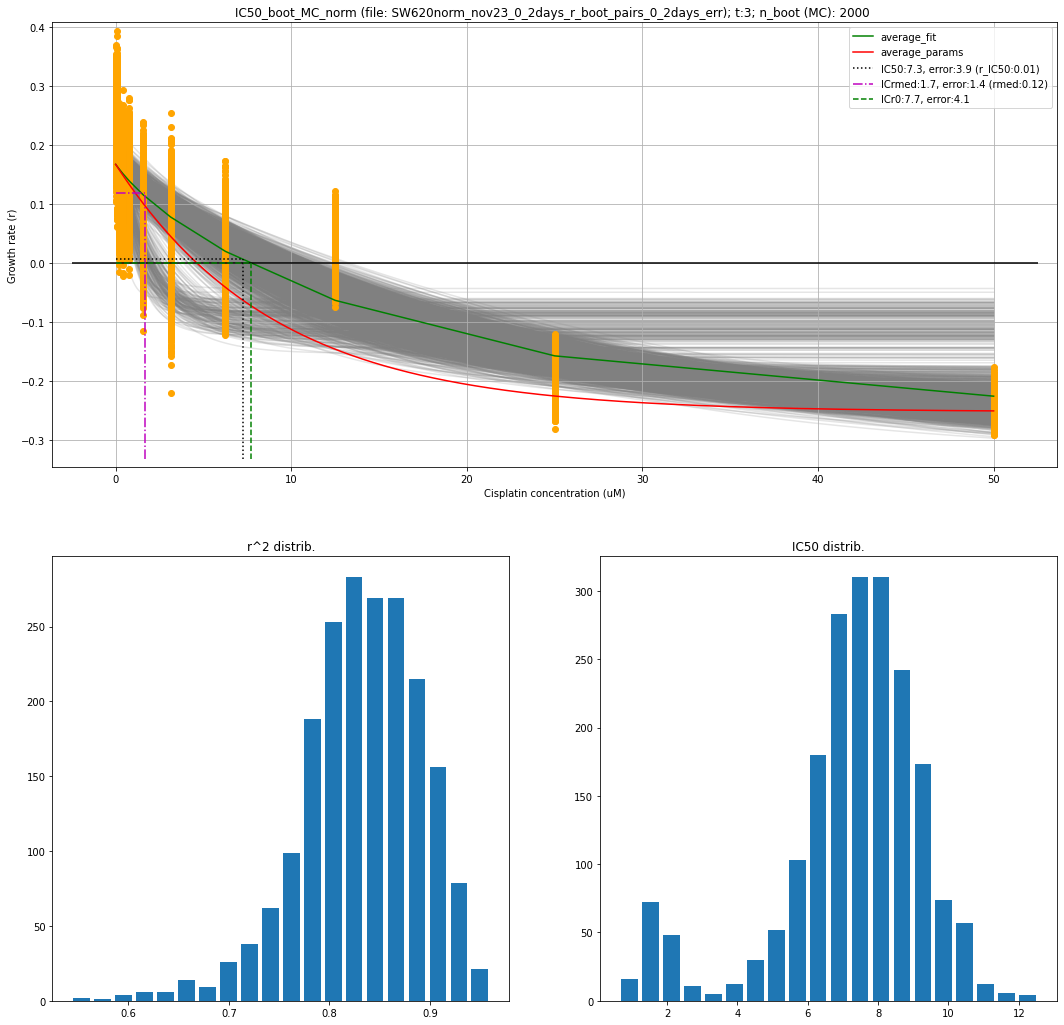

In [52]:
time_IC50 = 3
X=Concentr
y=slopes
e = err_slopes
# print('X', X)
# print('y', y)
n_times = 2
n_samples_fit_r= n_times * 9  ## n_Samples used in the fit (alldata or boot_pairs_all)

n_boot = 2000

IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv = \
    IC50_ICr0_ICrmed_nboot_MC_norm_estad(X,y, e, n_boot, n_samples_fit_r, time_IC50, name, save=False)

In [16]:
t = stats.t.ppf(0.95, n_samples-2) 
e_std = e/t
print('e_std:', e_std)
j=10
print('y0:',y0[j], ', e_std:', e_std[j])

e_std: 0     0.025357
1     0.033867
2     0.030083
3     0.032205
4     0.029945
5     0.034085
6     0.034990
7     0.038207
8     0.034126
9     0.033257
10    0.031178
Name: err_r, dtype: float64
y0: -0.1315050843361459 , e_std: 0.03117776138130381


In [51]:
y_MC = np.random.normal(y0[j],e_std[j], 1)[0]
print('y_MC:', y_MC)

y_MC: -0.07701534134252538


Assuming an exponential decay in the growth rate with the concentration:
$$r_q(C) =  A·e^{-\alpha C} - r_{\infty} \;\; (Eq.1)$$ 
where $r_{\infty}>0$ and $$r_q(C=0)=r_{Control} = r_{C0}$$
then:
$$r_q(C=0) =r_{C0} = A - r_{\infty} \Longrightarrow \; A=r_{C0}+r_{\infty} $$
then:
$$r_q(C) =  (r_{C0}+r_{\infty})·e^{-\alpha C} - r_{\infty} \;\; (Eq.2) $$ 
### Growth rate for Viability IC50
$$V(t)=\frac{N_q (t)}{N_0 (t)} = \frac{N_{0}'}{N_0}e^{(r_{q} - r_{C0})·t}$$
then, for a viability $V=0.5$:
$$V_{IC50}(t)=0.5=\frac{N_0'}{N_0}e^{(r_{IC50} - r_{C0})·t} \;\; (Eq.3) $$
then:
$$r_{IC50} = r_{C0}+\frac{ln(0.5)-ln(N_0'/N_0)}{t}$$
From Eq(2):
$$ \Longrightarrow C(IC50) = \frac{-1}{\alpha} ln \left(\frac{r_{IC50} + r_{\infty}}{r_{C0} + r_{\infty}} \right)$$
And with the fit parameters:
$$C(IC50) = \frac{-1}{b_{fit}} ln \left(\frac{r_{IC50} + c_{fit}}{a_{fit}} \right)$$

### Null growth rate (r=0)
For $r=0$, from Eq(1):
$$0 = (r_{C0}+r_{\infty})e^{-\alpha C(r=0)} - r_{\infty}$$
$$\Longrightarrow C(r=0)=\frac{-1}{\alpha}ln \left(\frac{r_{\infty}}{r_{C0}+r_{\infty}} \right) $$


In [ ]:
def IC50_ICr0_ICrmed_nboot_resid_pred_SE(X,y, n_boot, time, name, save=False): ## no se corta si no consigue el ajuste con curve_Fit, busca con el siguiente

    '''
    Calcula el valor de IC50, de ICr0 y el ICrmed (concentración para el que la tasa de crecimiento es la mitad que la del control)
    por el método de Bootstrap: itera tomando al azar valores
    aleatorios en el rango entre ymin-ymax para cada concentración, ajusta una exponencial decreciente desplazada
    y lo va promediando
    Devuelve el valor meadio de IC50, ICr0, ICrmed y sus desviaciones:
    ICr0mean, Delta_ICr0, IC50mean, Delta_IC50, ICrmed, Delta_ICrmed
    '''
    X = np.array(X).ravel()
    y0=np.array(y).ravel()
    print('y0',y0)
    r_IC50 = y[0]+np.log(0.5)/time
    rmed = y[0]/2.
    print('r_IC50:', r_IC50, 'r[0]:', y[0], 'rmed:', rmed)
    n_param = 3
    
    popt, pcov = curve_fit(f_exponen_shift, X, y)
    A = popt[0]
    B = popt[1]
    C = popt[2]
    print('param:',popt, 'A:',A, 'B:',B, 'C:', C)
    y_hat = f_exponen_shift(X, *popt)
    resid = y - y_hat
    print('resid:',resid)

    print('n_boot:', n_boot)
    n_points = n_boot
    n_samples = len(X)
    nparams = 3       ## Shifted exponential: A*exp(B * X) +C    
        
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float)
    slopes_b = np.zeros(n_boot, dtype=float)
    params_b = np.zeros((n_boot, n_param), dtype=float)

    IC50_b = np.zeros((n_boot), dtype = float)
    ICr0_b = np.zeros((n_boot), dtype = float)
    ICrmed_b = np.zeros((n_boot), dtype = float)
    IC50inv_b = np.zeros((n_boot), dtype = float)
    ICr0inv_b = np.zeros((n_boot), dtype = float)
    ICrmedinv_b = np.zeros((n_boot), dtype = float)
    errors_b = np.zeros((n_boot), dtype = float)

    errors = np.zeros(n_boot, dtype=float)
        
    fig = plt.figure(figsize=(10,6))
#     fig, axs = plt.subplots(2, 1, figsize=(10, 4))
#     subfigs = fig.add_subplot(2, 1, 1)
    

#     fig = plt.figure(figsize=(18,18))
#     gs = GridSpec(2, 2, figure=fig)
#     ax1 = fig.add_subplot(gs[0, :])
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[1, 1])
       
    npoints_plot = 1000
    X_plot = np.linspace(0,X[-1],npoints_plot)
#     y_plot_b = np.zeros((n_boot, npoints_plot), dtype=float)
    creciente = np.all(np.diff(X) > 0)
    print('Orden creciente:', creciente)
          
    nfit=0
    i_fit=0
    res_b = 0
    for i in range(n_boot):
#         print('iter/n_iter:',i, '/',n_boot)

            # Bootstrap: resample data with replacement
        i_index = np.random.choice(range(0, len(X)), len(X))
        resid_boot = resid[i_index]
#         print('shapes:', X.shape, A.shape, B.shape, resid_boot.shape)
#         print('resid_boot:', resid_boot)
        y_boot = f_exponen_shift(X, *popt) + resid_boot

#         X_boot = X[i_index]    
#         y_boot = y0[i_index]
#         print('X_boot, y_boot:', X_boot, y_boot)

        try:
            popt_b, pcov_b = curve_fit(f_exponen_shift, X, y_boot)
#             popt_b, pcov_b = curve_fit(f_exponen_shift, X_boot, y_boot)
            print('param:',popt)
            all_lt_10 = (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[2][2])<10) ##TODOS los parámetros tienen que ser < 2
            if all_lt_10:
                y_hat = f_exponen_shift(X, *popt_b)
#                 y_hat = f_exponen_shift(X_boot, *popt_b)
                res_b += y - y_hat
                y_hat_b[i_fit,:] = y_hat
                print('y_hat:', y_hat)
                creciente = np.all(np.diff(np.flip(y_hat)) > 0)
                if creciente:
                    print('creciente:', creciente)

    #                 IC50_b[i_fit] = np.interp(r_IC50, np.flip(y_hat), np.flip(X))
    #                 ICr0_b[i_fit] = np.interp(0., np.flip(y_hat), np.flip(X))
    #                 ICrmed_b[i_fit] = np.interp(rmed, np.flip(y_hat), np.flip(X))
                    IC50inv_b[i_fit] = f_exponen_shift_inv(r_IC50, *popt_b)
                    ICr0inv_b[i_fit] = f_exponen_shift_inv(0.0, *popt_b)
                    ICrmedinv_b[i_fit] = f_exponen_shift_inv(rmed, *popt_b)
                    errors_b[i_fit] = r2_score(y_boot, y_hat)

                    if (IC50inv_b[i_fit]<100) and (ICr0inv_b[i_fit]<100) and (ICrmedinv_b[i_fit]<100):                
                        params_b[i_fit,:] = popt_b[:]
                        print('params:', params_b[i_fit,:])
                        print('Función inversa -- IC50_b:', IC50inv_b[i_fit], 'ICr0_b:', ICr0inv_b[i_fit], 'ICrmed_b:', ICrmedinv_b[i_fit])

                        y_plot = f_exponen_shift( X_plot, *popt_b)
        #                 y_plot_b[i_fit,:] = y_plot
                        plt.plot(X_plot, y_plot, color='grey', alpha=0.2, zorder=1)
                        plt.scatter(X, y_boot, marker='o', color='orange', zorder=2)
        #                 ax1.scatter(X_boot, y_boot, marker='o', color='orange', zorder=2)
                        i_fit += 1
                        print('fit Ok, i',i, ', i_fit:', i_fit)

            
        except:
            print('error in curve_fit, i:',i,'\n')
    nfit = i_fit
    res_b /= nfit        
################
    print('i_fit:',i_fit, 'nfit:', nfit)    
    print('params_b[:20,:]', params_b[:20,:])
    params_mean = np.mean(params_b[:nfit,:], axis=0)

    IC50inv_mean = np.mean(IC50inv_b[:nfit])
    ICr0inv_mean = np.mean(ICr0inv_b[:nfit])
    ICrmedinv_mean = np.mean(ICrmedinv_b[:nfit])
    print('params_inv_mean=', params_mean)    
    
    sum_res2_IC50inv = np.sum((IC50inv_b[:nfit] - IC50inv_mean)**2)    
    sum_res2_ICr0inv = np.sum((ICr0inv_b[:nfit] - ICr0inv_mean)**2)    
    sum_res2_ICrmedinv = np.sum((ICrmedinv_b[:nfit] - ICrmedinv_mean)**2) 

    SE_IC50inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_IC50inv / (nfit-1)) ## 2 degrees of freedom
    SE_ICr0inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICr0inv / (nfit-1)) ## 2 degrees of freedom
    SE_ICrmedinv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICrmedinv / (nfit-1)) ## 2 degrees of freedom
    Interv_IC50inv = 1.96 * SE_IC50inv
    Interv_ICr0inv = 1.96 * SE_ICr0inv
    Interv_ICrmedinv = 1.96 * SE_ICrmedinv

    print('IC50inv_mean:',IC50inv_mean, 'SE_IC50inv:', SE_IC50inv, 'Interval:', Interv_IC50inv)
    print('ICr0inv_mean:',ICr0inv_mean, 'SE_ICr0inv:', SE_ICr0inv, 'Interval:', Interv_ICr0inv)
    print('ICrmedinv_mean:',ICrmedinv_mean, 'SE_ICrmedinv:', SE_ICrmedinv, 'Interval:', Interv_ICrmedinv)
        
    ymin_plot, ymax_plot = plt.ylim()
    xmin_plot, xmax_plot = plt.xlim()
    print('ymin', ymin_plot)
    plt.margins(0.01)
    
    yhat_mean = np.mean(y_hat_b, axis=0)
    yfit_mean = f_exponen_shift(X_plot, params_mean[0], params_mean[1], params_mean[2])
    plt.plot(X, yhat_mean, color='green')
    plt.plot(X_plot, yfit_mean, color='red')

    
    label_IC50 = f'IC50:{IC50inv_mean:.1f}, error:{Interv_IC50inv:.1f} (r_IC50:{r_IC50:.2f})' 
    plt.hlines(y=0, xmin=xmin_plot, xmax=xmax_plot, colors='black')
    plt.plot([IC50inv_mean, IC50inv_mean], [ymin_plot, r_IC50], 'k:', label=label_IC50) ##vertical
    plt.plot([0, IC50inv_mean], [r_IC50, r_IC50], 'k:') ##horizontal

    label_ICrmed = f'ICrmed:{ICrmedinv_mean:.1f}, error:{Interv_ICrmedinv:.1f} (rmed:{rmed:.2f})' 
    plt.plot([ICrmedinv_mean, ICrmedinv_mean], [ymin_plot, rmed], 'm-.' , label=label_ICrmed) ##vertical
    plt.plot([0, ICrmedinv_mean], [rmed, rmed], 'm-.') ##horizontal

    label_ICr0 =f'ICr0:{ICr0inv_mean:.1f}, error:{Interv_ICr0inv:.1f}' 
    plt.plot([ICr0inv_mean, ICr0inv_mean], [ymin_plot, 0], 'g--', label=label_ICr0) ##vertical
    plt.plot([0, ICr0inv_mean], [0,0],  'g--') ##horizontal
    
    plt.xlabel('Cisplatin concentration (uM)')
    plt.ylabel('Growth rate (r)')
    plt.title(f'Growth rate (file: {name}); t:{time}; n_boot: {n_boot} (exponential fit))')
    plt.grid(True)
    plt.legend()
        
    if save:
        filename = name + 'prom_r_weight_C_IC50_ICrmed_ICr0_bootstrap_SE.jpg'
        plt.savefig(filename)

    plt.show()
    
    return (IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv)

In [ ]:
def IC50_ICr0_ICrmed_nboot_resid_pred_SE_weight(X,y, e, n_boot, time, name, save=False): ## no se corta si no consigue el ajuste con curve_Fit, busca con el siguiente

    '''
    Calcula el valor de IC50, de ICr0 y el ICrmed (concentración para el que la tasa de crecimiento es la mitad que la del control)
    por el método de Bootstrap: itera tomando al azar valores
    aleatorios en el rango entre ymin-ymax para cada concentración, ajusta una exponencial decreciente desplazada
    y lo va promediando
    Devuelve el valor meadio de IC50, ICr0, ICrmed y sus desviaciones:
    ICr0mean, Delta_ICr0, IC50mean, Delta_IC50, ICrmed, Delta_ICrmed
    '''
    y0=np.array(y).ravel()
    print('y0',y0)
    r_IC50 = y[0]+np.log(0.5)/time
    rmed = y[0]/2.
    print('r_IC50:', r_IC50, 'r[0]:', y[0], 'rmed:', rmed)
    n_param = 3
    
    popt, pcov = curve_fit(f_exponen_shift, X, y, sigma=e, absolute_sigma = True)
    A = popt[0]
    B = popt[1]
    C = popt[2]
    print('param:',popt, 'A:',A, 'B:',B, 'C:', C)
    y_hat = f_exponen_shift(X, *popt)
    resid = y - y_hat
    print('resid:',resid)

    print('n_boot:', n_boot)
    n_points = n_boot
    n_samples = len(X)
    nparams = 3       ## Shifted exponential: A*exp(B * X) +C    
        
    y_hat_b = np.zeros((n_boot, n_samples), dtype=float)
    slopes_b = np.zeros(n_boot, dtype=float)
    params_b = np.zeros((n_boot, n_param), dtype=float)

    IC50_b = np.zeros((n_boot), dtype = float)
    ICr0_b = np.zeros((n_boot), dtype = float)
    ICrmed_b = np.zeros((n_boot), dtype = float)
    IC50inv_b = np.zeros((n_boot), dtype = float)
    ICr0inv_b = np.zeros((n_boot), dtype = float)
    ICrmedinv_b = np.zeros((n_boot), dtype = float)
    errors_b = np.zeros((n_boot), dtype = float)

    errors = np.zeros(n_boot, dtype=float)
        
    fig = plt.figure(figsize=(10,6))
#     fig, axs = plt.subplots(2, 1, figsize=(10, 4))
#     subfigs = fig.add_subplot(2, 1, 1)
    

#     fig = plt.figure(figsize=(18,18))
#     gs = GridSpec(2, 2, figure=fig)
#     ax1 = fig.add_subplot(gs[0, :])
#     ax2 = fig.add_subplot(gs[1, 0])
#     ax3 = fig.add_subplot(gs[1, 1])
       
    npoints_plot = 1000
    X_plot = np.linspace(0,X[-1],npoints_plot)
#     y_plot_b = np.zeros((n_boot, npoints_plot), dtype=float)
    creciente = np.all(np.diff(X) > 0)
    print('Orden creciente:', creciente)
          
    nfit=0
    i_fit=0
    res_b = 0
    for i in range(n_boot):
#         print('iter/n_iter:',i, '/',n_boot)

            # Bootstrap: resample data with replacement
        i_index = np.random.choice(range(0, len(X)), len(X))
        resid_boot = resid[i_index]
#         print('shapes:', X.shape, A.shape, B.shape, resid_boot.shape)
        print('resid_boot:', resid_boot)
        y_boot = f_exponen_shift(X, *popt) + resid_boot

#         X_boot = X[i_index]    
#         y_boot = y0[i_index]
#         print('X_boot, y_boot:', X_boot, y_boot)

        try:
            popt_b, pcov_b = curve_fit(f_exponen_shift, X, y_boot)
#             popt_b, pcov_b = curve_fit(f_exponen_shift, X_boot, y_boot)
            print('param:',popt)
            all_lt_10 = (np.abs(popt_b)<10).all() and (np.sqrt(pcov_b[2][2])<10) ##TODOS los parámetros tienen que ser < 2
            if all_lt_10:
                y_hat = f_exponen_shift(X, *popt_b)
#                 y_hat = f_exponen_shift(X_boot, *popt_b)
                res_b += y - y_hat
                y_hat_b[i_fit,:] = y_hat
                print('y_hat:', y_hat)
                creciente = np.all(np.diff(np.flip(y_hat)) > 0)
                if creciente:
                    print('creciente:', creciente)

    #                 IC50_b[i_fit] = np.interp(r_IC50, np.flip(y_hat), np.flip(X))
    #                 ICr0_b[i_fit] = np.interp(0., np.flip(y_hat), np.flip(X))
    #                 ICrmed_b[i_fit] = np.interp(rmed, np.flip(y_hat), np.flip(X))
                    IC50inv_b[i_fit] = f_exponen_shift_inv(r_IC50, *popt_b)
                    ICr0inv_b[i_fit] = f_exponen_shift_inv(0.0, *popt_b)
                    ICrmedinv_b[i_fit] = f_exponen_shift_inv(rmed, *popt_b)
                    errors_b[i_fit] = r2_score(y_boot, y_hat)

                    if (IC50inv_b[i_fit]<100) and (ICr0inv_b[i_fit]<100) and (ICrmedinv_b[i_fit]<100):                
                        params_b[i_fit,:] = popt_b[:]
                        print('params:', params_b[i_fit,:])
                        print('Función inversa -- IC50_b:', IC50inv_b[i_fit], 'ICr0_b:', ICr0inv_b[i_fit], 'ICrmed_b:', ICrmedinv_b[i_fit])

                        y_plot = f_exponen_shift( X_plot, *popt_b)
        #                 y_plot_b[i_fit,:] = y_plot
                        plt.plot(X_plot, y_plot, color='grey', alpha=0.2, zorder=1)
                        plt.scatter(X, y_boot, marker='o', color='orange', zorder=2)
        #                 ax1.scatter(X_boot, y_boot, marker='o', color='orange', zorder=2)
                        i_fit += 1
                        print('fit Ok, i',i, ', i_fit:', i_fit)

            
        except:
            print('error in curve_fit, i:',i,'\n')
    nfit = i_fit
    res_b /= nfit        
################
    print('i_fit:',i_fit, 'nfit:', nfit)    
    print('params_b[:20,:]', params_b[:20,:])
    params_mean = np.mean(params_b[:nfit,:], axis=0)

    IC50inv_mean = np.mean(IC50inv_b[:nfit])
    ICr0inv_mean = np.mean(ICr0inv_b[:nfit])
    ICrmedinv_mean = np.mean(ICrmedinv_b[:nfit])
    print('params_inv_mean=', params_mean)    
    
    sum_res2_IC50inv = np.sum((IC50inv_b[:nfit] - IC50inv_mean)**2)    
    sum_res2_ICr0inv = np.sum((ICr0inv_b[:nfit] - ICr0inv_mean)**2)    
    sum_res2_ICrmedinv = np.sum((ICrmedinv_b[:nfit] - ICrmedinv_mean)**2) 

    SE_IC50inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_IC50inv / (nfit-1)) ## 2 degrees of freedom
    SE_ICr0inv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICr0inv / (nfit-1)) ## 2 degrees of freedom
    SE_ICrmedinv = np.sqrt(n_samples/(n_samples-1)) * np.sqrt( sum_res2_ICrmedinv / (nfit-1)) ## 2 degrees of freedom
    Interv_IC50inv = 1.96 * SE_IC50inv
    Interv_ICr0inv = 1.96 * SE_ICr0inv
    Interv_ICrmedinv = 1.96 * SE_ICrmedinv

    print('IC50inv_mean:',IC50inv_mean, 'SE_IC50inv:', SE_IC50inv, 'Interval:', Interv_IC50inv)
    print('ICr0inv_mean:',ICr0inv_mean, 'SE_ICr0inv:', SE_ICr0inv, 'Interval:', Interv_ICr0inv)
    print('ICrmedinv_mean:',ICrmedinv_mean, 'SE_ICrmedinv:', SE_ICrmedinv, 'Interval:', Interv_ICrmedinv)
        
    ymin_plot, ymax_plot = plt.ylim()
    xmin_plot, xmax_plot = plt.xlim()
    print('ymin', ymin_plot)
    plt.margins(0.01)
    
    yhat_mean = np.mean(y_hat_b, axis=0)
    yfit_mean = f_exponen_shift(X_plot, params_mean[0], params_mean[1], params_mean[2])
    plt.plot(X, yhat_mean, color='green')
    plt.plot(X_plot, yfit_mean, color='red')

    
    label_IC50 = f'IC50:{IC50inv_mean:.1f}, error:{Interv_IC50inv:.1f} (r_IC50:{r_IC50:.2f})' 
    plt.hlines(y=0, xmin=xmin_plot, xmax=xmax_plot, colors='black')
    plt.plot([IC50inv_mean, IC50inv_mean], [ymin_plot, r_IC50], 'k:', label=label_IC50) ##vertical
    plt.plot([0, IC50inv_mean], [r_IC50, r_IC50], 'k:') ##horizontal

    label_ICrmed = f'ICrmed:{ICrmedinv_mean:.1f}, error:{Interv_ICrmedinv:.1f} (rmed:{rmed:.2f})' 
    plt.plot([ICrmedinv_mean, ICrmedinv_mean], [ymin_plot, rmed], 'm-.' , label=label_ICrmed) ##vertical
    plt.plot([0, ICrmedinv_mean], [rmed, rmed], 'm-.') ##horizontal

    label_ICr0 =f'ICr0:{ICr0inv_mean:.1f}, error:{Interv_ICr0inv:.1f}' 
    plt.plot([ICr0inv_mean, ICr0inv_mean], [ymin_plot, 0], 'g--', label=label_ICr0) ##vertical
    plt.plot([0, ICr0inv_mean], [0,0],  'g--') ##horizontal
    
    plt.xlabel('Cisplatin concentration (uM)')
    plt.ylabel('Growth rate (r)')
    plt.title(f'Growth rate (file: {name}); t:{time}; n_boot: {n_boot} (exponential fit))')
    plt.grid(True)
    plt.legend()
        
    if save:
        filename = name + 'prom_r_weight_C_IC50_ICrmed_ICr0_bootstrap_SE_weight.jpg'
        plt.savefig(filename)

    plt.show()
    
    return (IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv)

###  Calcula IC50, ICr0 e ICrmed y lo representa CON  las ESTADÍSTICAS

In [ ]:
time = 3
X=Concentr
y=slopes
e = err_slopes
print('X', X)
print('y', y)
n_boot = 2000
IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv = \
    IC50_ICr0_ICrmed_nboot_resid_pred_SE_weight(X,y, e, n_boot, time, name, save=False)

In [ ]:
time = 3
X=X0
y=y0
# e = err_slopes
print('X', X)
print('y', y)
n_boot = 2000
IC50inv_mean, Interv_IC50inv, ICr0inv_mean, Interv_ICr0inv, ICrmedinv_mean, Interv_ICrmedinv = \
    IC50_ICr0_ICrmed_nboot_resid_pred_SE(X,y, n_boot, time, name, save=False)

#### Poner el número de "n_boot"  y el párametro "save" si se quiere guardar la figura